<a href="https://colab.research.google.com/github/itssofiarce/AA1-TUIA-Petetta-Arce/blob/main/TP_integrador_AA1_Petetta_Arce.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
!pip3 install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 8.8 MB/s eta 0:00:00


In [9]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 8.2 MB/s eta 0:00:00


In [10]:
!pip install tensorflow

In [11]:
#!pip install pandas

In [221]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from math import sqrt

# De scikit-learn...

# Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PowerTransformer

# Estandarización y modelado
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

from sklearn.compose import make_column_selector
# Division de los datos
from sklearn.model_selection import train_test_split, RandomizedSearchCV

# Normalización
from sklearn.preprocessing import MinMaxScaler

# Regresiones
from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso, ElasticNet, RidgeCV, ElasticNetCV, LassoCV, LogisticRegression

# ML metricas
from sklearn.metrics import mean_squared_error, r2_score, classification_report, roc_curve, auc, confusion_matrix, accuracy_score, precision_score,ConfusionMatrixDisplay, mean_absolute_percentage_error, mean_absolute_error

# Validación Cruzada
from sklearn.model_selection import cross_val_score, StratifiedKFold, KFold, LeaveOneOut

# Explicabilidad
import shap

# Redes Neuronales
from setuptools import setup
from distutils.core import setup
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Precision
from tensorflow.keras.utils import to_categorical
from keras.optimizers import Adam

# Optimización de HP
import optuna
from optuna.trial import Trial


In [14]:
#path= 'weatherAUS.csv'
path = '/content/drive/MyDrive/weatherAUS.csv'
df = pd.read_csv(path, usecols=range(1,25))
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No,0.0
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No,0.0
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No,0.0
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No,1.0
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No,0.2


In [15]:
### Columnas
df.columns

Index(['Date', 'Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation',
       'Sunshine', 'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'RainTomorrow', 'RainfallTomorrow'],
      dtype='object')

In [16]:
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainfallTomorrow
count,143928.000000,144159.000000,142152.000000,82658.000000,75616.000000,135159.000000,143645.000000,142351.000000,142759.000000,140907.000000,130351.000000,130388.000000,89542.000000,86076.000000,143646.000000,141805.000000,142153.000000
mean,12.195873,23.223176,2.361516,5.468616,7.611241,40.036564,14.044742,18.663164,68.877290,51.537432,1017.649277,1015.255184,4.447287,4.509770,16.992780,21.685249,2.361242
std,6.398018,7.118770,8.479338,4.193871,3.785612,13.607212,8.915610,8.810276,19.029576,20.796720,7.107132,7.037981,2.887161,2.720306,6.488045,6.936358,8.479084
min,-8.500000,-4.800000,0.000000,0.000000,0.000000,6.000000,0.000000,0.000000,0.000000,0.000000,980.500000,977.100000,0.000000,0.000000,-7.200000,-5.400000,0.000000
25%,7.600000,17.900000,0.000000,2.600000,4.800000,31.000000,7.000000,13.000000,57.000000,37.000000,1012.900000,1010.400000,1.000000,2.000000,12.300000,16.600000,0.000000
50%,12.000000,22.600000,0.000000,4.800000,8.400000,39.000000,13.000000,19.000000,70.000000,52.000000,1017.600000,1015.200000,5.000000,5.000000,16.700000,21.100000,0.000000
75%,16.900000,28.200000,0.800000,7.400000,10.600000,48.000000,19.000000,24.000000,83.000000,66.000000,1022.400000,1020.000000,7.000000,7.000000,21.600000,26.400000,0.800000
max,33.900000,48.100000,371.000000,145.000000,14.500000,135.000000,130.000000,87.000000,100.000000,100.000000,1041.000000,1039.600000,9.000000,9.000000,40.200000,46.700000,371.000000


In [17]:
### Cantidad de valores faltantes.
df.isna().sum()

Date                    0
Location                0
MinTemp              1484
MaxTemp              1253
Rainfall             3260
Evaporation         62754
Sunshine            69796
WindGustDir         10316
WindGustSpeed       10253
WindDir9am          10562
WindDir3pm           4226
WindSpeed9am         1767
WindSpeed3pm         3061
Humidity9am          2653
Humidity3pm          4505
Pressure9am         15061
Pressure3pm         15024
Cloud9am            55870
Cloud3pm            59336
Temp9am              1766
Temp3pm              3607
RainToday            3260
RainTomorrow         3259
RainfallTomorrow     3259
dtype: int64

In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145412 entries, 0 to 145411
Data columns (total 24 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Date              145412 non-null  object 
 1   Location          145412 non-null  object 
 2   MinTemp           143928 non-null  float64
 3   MaxTemp           144159 non-null  float64
 4   Rainfall          142152 non-null  float64
 5   Evaporation       82658 non-null   float64
 6   Sunshine          75616 non-null   float64
 7   WindGustDir       135096 non-null  object 
 8   WindGustSpeed     135159 non-null  float64
 9   WindDir9am        134850 non-null  object 
 10  WindDir3pm        141186 non-null  object 
 11  WindSpeed9am      143645 non-null  float64
 12  WindSpeed3pm      142351 non-null  float64
 13  Humidity9am       142759 non-null  float64
 14  Humidity3pm       140907 non-null  float64
 15  Pressure9am       130351 non-null  float64
 16  Pressure3pm       13

In [19]:
df['Location'].unique()

array(['Albury', 'BadgerysCreek', 'Cobar', 'CoffsHarbour', 'Moree',
       'Newcastle', 'NorahHead', 'NorfolkIsland', 'Penrith', 'Richmond',
       'Sydney', 'SydneyAirport', 'WaggaWagga', 'Williamtown',
       'Wollongong', 'Canberra', 'Tuggeranong', 'MountGinini', 'Ballarat',
       'Bendigo', 'Sale', 'MelbourneAirport', 'Melbourne', 'Mildura',
       'Nhil', 'Portland', 'Watsonia', 'Dartmoor', 'Brisbane', 'Cairns',
       'GoldCoast', 'Townsville', 'Adelaide', 'MountGambier', 'Nuriootpa',
       'Woomera', 'Albany', 'Witchcliffe', 'PearceRAAF', 'PerthAirport',
       'Perth', 'SalmonGums', 'Walpole', 'Hobart', 'Launceston',
       'AliceSprings', 'Darwin', 'Katherine', 'Uluru'], dtype=object)

In [20]:
costa_este = ["Adelaide", "Canberra", "Cobar", "Dartmoor", "Melbourne", "MelbourneAirport", "MountGambier", "Sydney", "SydneyAirport"]

df.loc[df['Location'].isin(costa_este), 'Location'] = 'costa_este'

df = df[df['Location'] == 'costa_este']

df = df.reset_index(drop=True)

In [21]:
df.head()

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow,RainfallTomorrow
0,2009-01-01,costa_este,17.9,35.2,0.0,12.0,12.3,SSW,48.0,ENE,...,13.0,1006.3,1004.4,2.0,5.0,26.6,33.4,No,No,0.0
1,2009-01-02,costa_este,18.4,28.9,0.0,14.8,13.0,S,37.0,SSE,...,8.0,1012.9,1012.1,1.0,1.0,20.3,27.0,No,No,0.0
2,2009-01-03,costa_este,15.5,34.1,0.0,12.6,13.3,SE,30.0,NaN,...,7.0,NaN,1011.6,NaN,1.0,NaN,32.7,No,No,0.0
3,2009-01-04,costa_este,19.4,37.6,0.0,10.8,10.6,NNE,46.0,NNE,...,22.0,1012.3,1009.2,1.0,6.0,28.7,34.9,No,No,0.0
4,2009-01-05,costa_este,21.9,38.4,0.0,11.4,12.2,WNW,31.0,WNW,...,22.0,1012.7,1009.1,1.0,5.0,29.1,35.6,No,No,0.0


In [22]:
### Busco duplicados
if not df.duplicated().any():
  print('No hay registros duplicados')

No hay registros duplicados


In [23]:
df.isnull().sum()

Date                   0
Location               0
MinTemp              570
MaxTemp              558
Rainfall             986
Evaporation         4353
Sunshine            6713
WindGustDir         1645
WindGustSpeed       1642
WindDir9am          1648
WindDir3pm           437
WindSpeed9am         358
WindSpeed3pm         340
Humidity9am          940
Humidity3pm          890
Pressure9am          839
Pressure3pm          829
Cloud9am            9367
Cloud3pm            9550
Temp9am              585
Temp3pm              576
RainToday            986
RainTomorrow         985
RainfallTomorrow     985
dtype: int64

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28233 entries, 0 to 28232
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              28233 non-null  object 
 1   Location          28233 non-null  object 
 2   MinTemp           27663 non-null  float64
 3   MaxTemp           27675 non-null  float64
 4   Rainfall          27247 non-null  float64
 5   Evaporation       23880 non-null  float64
 6   Sunshine          21520 non-null  float64
 7   WindGustDir       26588 non-null  object 
 8   WindGustSpeed     26591 non-null  float64
 9   WindDir9am        26585 non-null  object 
 10  WindDir3pm        27796 non-null  object 
 11  WindSpeed9am      27875 non-null  float64
 12  WindSpeed3pm      27893 non-null  float64
 13  Humidity9am       27293 non-null  float64
 14  Humidity3pm       27343 non-null  float64
 15  Pressure9am       27394 non-null  float64
 16  Pressure3pm       27404 non-null  float6

In [25]:
df.describe()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainfallTomorrow
count,27663.000000,27675.000000,27247.000000,23880.000000,21520.000000,26591.000000,27875.000000,27893.000000,27293.000000,27343.000000,27394.000000,27404.000000,18866.000000,18683.000000,27648.000000,27657.000000,27248.000000
mean,11.263319,21.902078,2.050369,4.826499,6.891129,41.835471,15.130152,20.023052,68.766350,50.497385,1018.249325,1016.149624,4.668557,4.732805,15.477127,20.408345,2.049347
std,5.709936,6.693168,6.384560,3.707995,3.867622,14.186300,9.458606,8.979409,18.730306,19.944931,7.423776,7.267376,2.807571,2.628154,5.701031,6.532302,6.383931
min,-8.000000,4.100000,0.000000,0.000000,0.000000,9.000000,0.000000,0.000000,5.000000,1.000000,982.300000,984.900000,0.000000,0.000000,-1.300000,3.700000,0.000000
25%,7.400000,16.600000,0.000000,2.200000,3.800000,31.000000,9.000000,13.000000,57.000000,37.000000,1013.300000,1011.300000,1.000000,2.000000,11.400000,15.400000,0.000000
50%,10.900000,21.000000,0.000000,4.000000,7.400000,39.000000,13.000000,19.000000,70.000000,50.000000,1018.400000,1016.300000,6.000000,6.000000,15.000000,19.500000,0.000000
75%,15.200000,26.200000,1.000000,6.600000,10.000000,50.000000,20.000000,26.000000,83.000000,64.000000,1023.300000,1021.100000,7.000000,7.000000,19.125000,24.500000,1.000000
max,33.900000,46.800000,119.400000,86.200000,14.300000,122.000000,69.000000,76.000000,100.000000,100.000000,1040.600000,1037.900000,9.000000,8.000000,38.600000,46.100000,119.400000


# Analisis Exploratorio

## Correlación

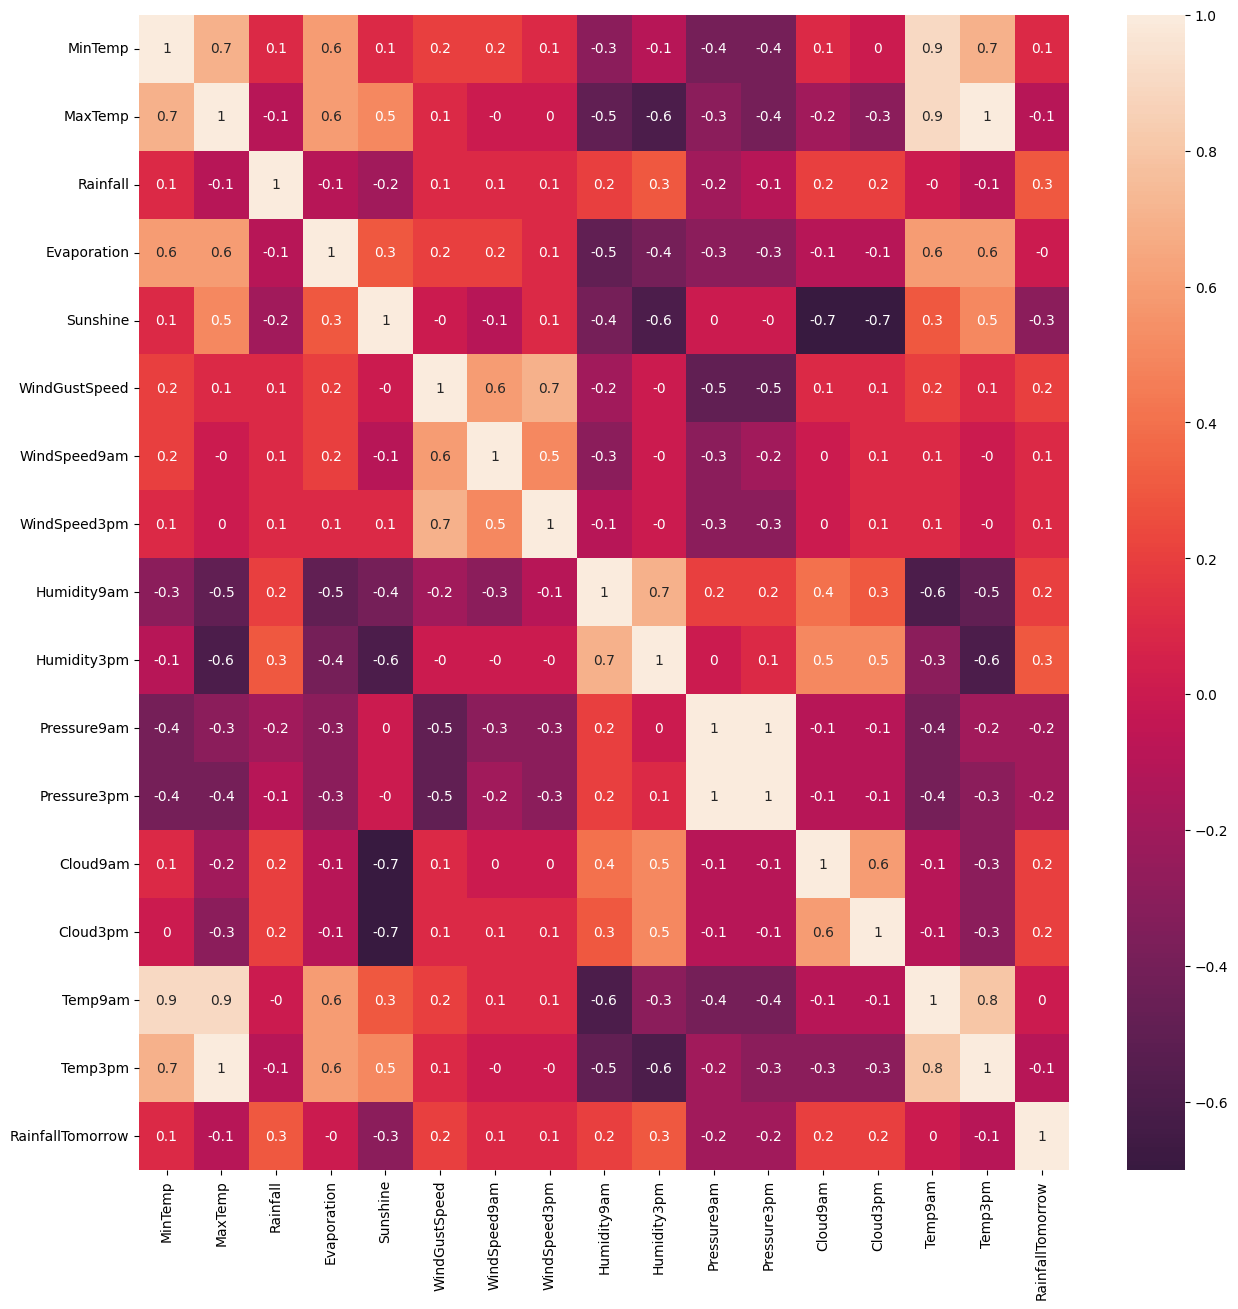

In [26]:
num_col = df.select_dtypes(include=['float64'])
corr = num_col.corr().round(1)
plt.figure(figsize=(15, 15))
sns.heatmap(corr, annot=True, cmap="rocket", center=0)
plt.show()

<Axes: xlabel='Humidity9am', ylabel='Humidity3pm'>

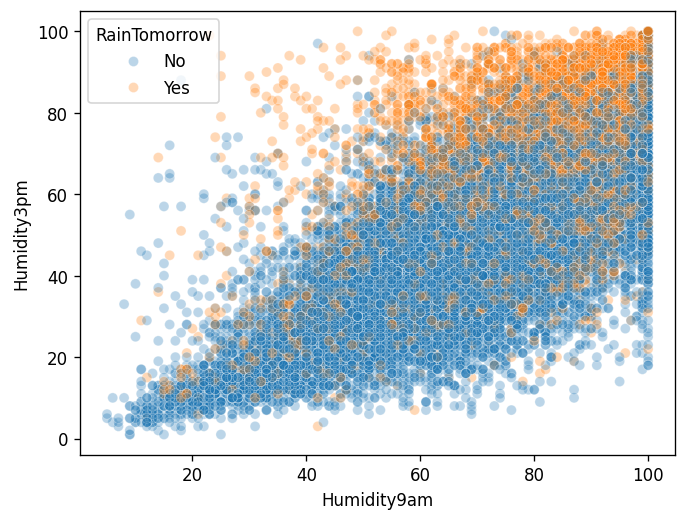

In [27]:
### scatter_plots entre variables que tienen una alta correlación
### Humedad
num_col['RainTomorrow'] = df['RainTomorrow']
plt.figure(dpi=120)
sns.scatterplot(num_col, x='Humidity9am', y='Humidity3pm', hue='RainTomorrow', alpha=0.3)


Segun el gráfico, se observa si ambos valores de humedad son altos, entonces hay grandes chances de lluvia

<Axes: xlabel='Pressure9am', ylabel='Pressure3pm'>

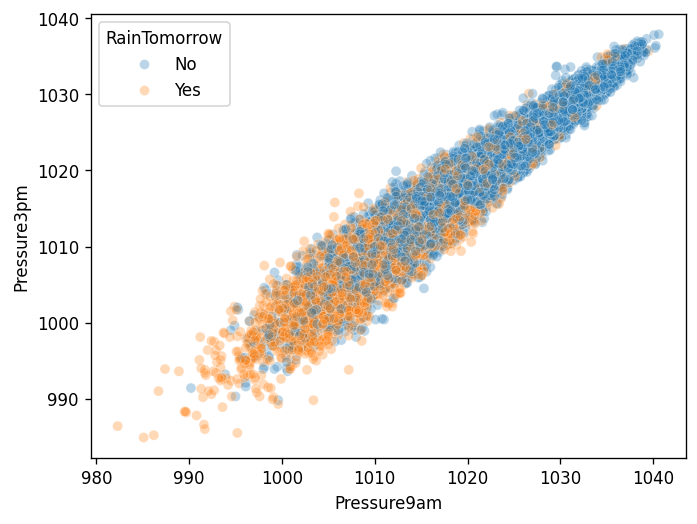

In [28]:
### Presión
plt.figure(dpi=120)
sns.scatterplot(num_col, x='Pressure9am', y='Pressure3pm', hue='RainTomorrow', alpha=0.3)

Segun el gráfico, si la presión de las 9am es baja al igual que la de las 3pm entonces hay grandes chances de lluvia

<Axes: xlabel='MaxTemp', ylabel='MinTemp'>

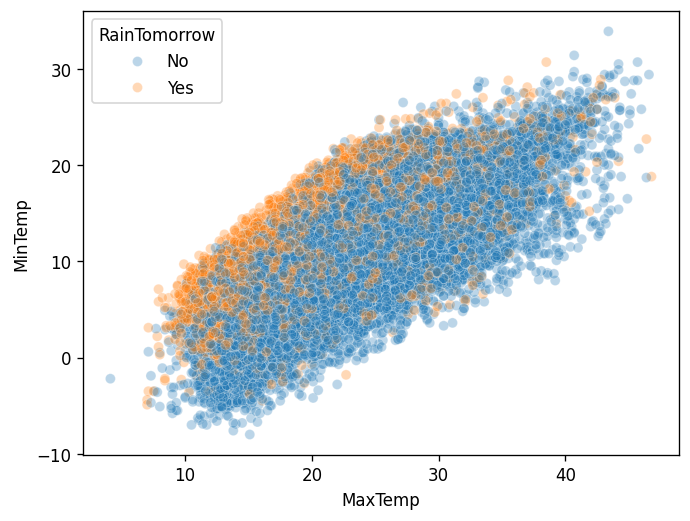

In [29]:
### Temperatura
plt.figure(dpi=120)
sns.scatterplot(num_col, x='MaxTemp', y='MinTemp', hue='RainTomorrow', alpha=0.3)

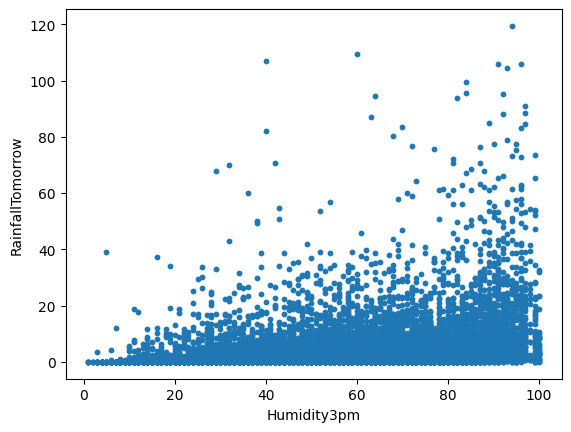

<Figure size 300x200 with 0 Axes>

In [30]:
# Relación entre la Humedad a las 3pm y la cantidad de lluvia de mañana
f ,ax = plt.subplots()
plt.figure(figsize=(3, 2))
ax.scatter(num_col['Humidity3pm'], num_col['RainfallTomorrow'], s= 10)
ax.set_xlabel('Humidity3pm')
ax.set_ylabel('RainfallTomorrow')
plt.show()

Segun el gráfico, se observa una tendencia de que a mayor humedad de las 3pm mayor cantidad de lluvia

<Axes: xlabel='RainfallTomorrow', ylabel='Density'>

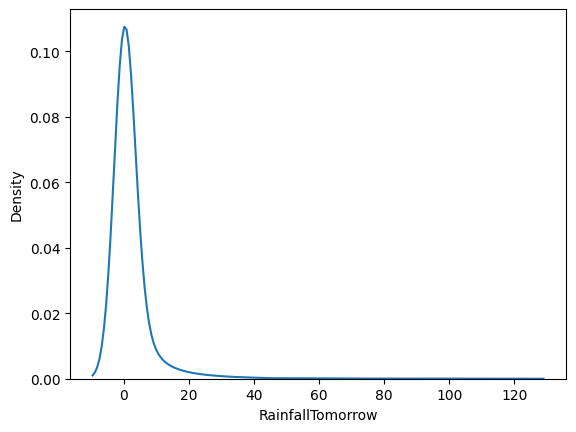

In [31]:
# Distribución de RainfallTomorrow
sns.kdeplot(num_col['RainfallTomorrow'], bw_method=0.5)

Segun el gráfico, se observan gran cantidad de outliers

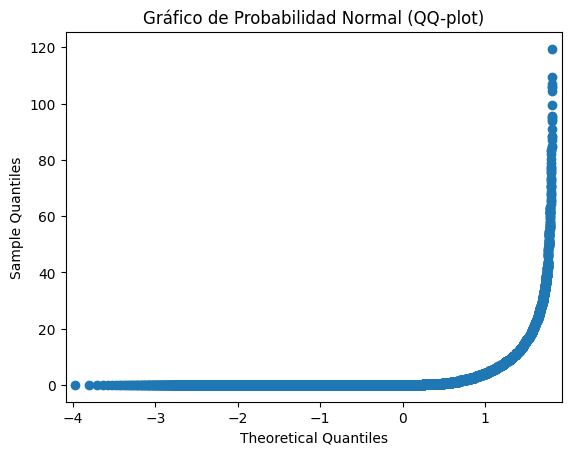

In [32]:
#  QQ-plot
sm.qqplot((num_col['RainfallTomorrow']))
plt.title("Gráfico de Probabilidad Normal (QQ-plot)")
plt.show()

La distribución de la variable a predecir no presenta normalidad

## Pipeline

* Descartar Unnamed y Date porque son features que no vamos a utilizar: **ColDropper** (Ademas droppear RainfallTomorrow para prevenir la fuga de datos)
* Descartar todas las location que no son necesarias: **LocDropper**
* Dropear nulos y Label Encoding para las variables yes/no: **BoolYNDropperEncoder**
* Imputar valores nulos en variables categoricas con la moda: **CatFiller**
* Imputar valores nulos en variables numericas con la media:  **NumFiller**
* One Hot Encoding para las location: **LocEncoder**
* Encoding en sin y cos para WinDir: **CoordRecat**
* Estandarizar valores: **Standarizer**


In [33]:
class ColDropper(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
        return self

  def transform(self, X):
    return X.drop(['Unnamed: 0', 'Date', 'RainTomorrow'], axis=1)

In [34]:
class LocDropper(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
        return self

  def transform(self, X):
    aus_loc = [' Adelaide', 'Canberra', 'Cobar', 'Dartmoor', 'Melbourne', 'MelbourneAirport', 'MountGambier', 'Sydney', 'SydneyAirport' ]
    return X[X['Location'].isin(aus_loc)]

In [35]:
class CatFiller(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
      X['WindGustDir'] = X.groupby('Location')['WindGustDir'].transform(lambda x: x.fillna(x.mode()[0]))
      X['WindDir9am'] = X.groupby('Location')['WindDir9am'].transform(lambda x: x.fillna(x.mode()[0]))
      X['WindDir3pm'] = X.groupby('Location')['WindDir3pm'].transform(lambda x: x.fillna(x.mode()[0]))

      return X

In [36]:
class NumFiller(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
      remanining_vnul_columns = X.columns[X.isna().any()].tolist()
      for col in remanining_vnul_columns:
        X[col] =  X[col].fillna(X[col].mean())

      return X

In [37]:
# https://www.mdpi.com/2078-2489/13/4/163 Como las variables de la dirección de los vientos pueden tener hasta 16 direcciones diferentes, para convertirlos a variables numéricas, se tiene encuenta una distribución circular. Por eso, cada una de las variables se dividió en dos: Una con el seno y otra con el coseno del angulo
class CoordRecat(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        coord = {
            'N': 0, 'NNE': 22.5, 'NE': 45, 'ENE': 67.5,
            'E': 90, 'ESE': 112.5, 'SE': 135, 'SSE': 157.5,
            'S': 180, 'SSW': 202.5, 'SW': 225, 'WSW': 247.5,
            'W': 270, 'WNW': 292.5, 'NW': 315, 'NNW': 337.5,
        }

        # Aplicar la recategorización
        for col in ['WindGustDir', 'WindDir9am', 'WindDir3pm']:
            X[col] = X[col].map(coord)
            X[f'{col}_rad'] = np.deg2rad(X[col])
            X[f'{col}_sin'] = np.sin(X[f'{col}_rad']).round(5)
            X[f'{col}_cos'] = np.cos(X[f'{col}_rad']).round(5)

        # Eliminar columnas originales y columnas radianes
        columns_to_drop = [f'{col}_rad' for col in ['WindGustDir', 'WindDir9am', 'WindDir3pm']] + ['WindGustDir', 'WindDir9am', 'WindDir3pm']
        X = X.drop(columns=columns_to_drop, axis=1)

        return X

In [38]:
class LocEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
      dummies = pd.get_dummies(X['Location'], dtype=int)
      X = pd.concat([X, dummies], axis=1)
      X.drop('Location', axis=1, inplace=True)

      return X

In [39]:
class ResetIndex(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X.reset_index(drop=True)

In [40]:
class Standarizer(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
      return self
  def transform(self, X):
    # Exclusión de variables booleanas y RainfallTmorrow porque no serán estandarizaradas
    exc_c = ['RainToday', 'RainTomorrow', 'RainfallTomorrow']

    # Estandarización
    df_sub = X[[col for col in X.columns if col not in exc_c]]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_sub)

    X_scaled = pd.DataFrame(X_scaled, columns=df_sub.columns)
    for col in exc_c:
      X_scaled[f'{col}'] = X[col]

    # Nuevo DataFrame estandarizado con los nombres de las columnas originales
    return X_scaled

In [41]:
class OutliersTreater(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
      return self
  def transform(self, X):
    cols_with_ouliers=['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm']

    for col in cols_with_ouliers:
      IQR=X[col].quantile(0.75)-X[col].quantile(0.25)
      lower_bridge=X[col].quantile(0.25)-(IQR*1.5)
      upper_bridge=X[col].quantile(0.75)+(IQR*1.5)

      X.loc[X[col]>=round(upper_bridge,2),col]=round(upper_bridge,2)
      X.loc[X[col]<=round(lower_bridge,2),col]=round(lower_bridge,2)

    return X

In [42]:
class ColDropper(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
        return self

  def transform(self, X):
    return X.drop(['Date'], axis=1)

In [43]:
class LocDropper(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
        return self

  def transform(self, X):
    costa_este = [' Adelaide', 'Canberra', 'Cobar', 'Dartmoor', 'Melbourne', 'MelbourneAirport', 'MountGambier', 'Sydney', 'SydneyAirport' ]
    X.loc[X['Location'].isin(costa_este), 'Location'] = 'costa_este'
    return X[X['Location'] == 'costa_este']

In [44]:
class CatFiller(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
      X['WindGustDir'] = X.groupby('Location')['WindGustDir'].transform(lambda x: x.fillna(x.mode()[0]))
      X['WindDir9am'] = X.groupby('Location')['WindDir9am'].transform(lambda x: x.fillna(x.mode()[0]))
      X['WindDir3pm'] = X.groupby('Location')['WindDir3pm'].transform(lambda x: x.fillna(x.mode()[0]))

      return X

In [45]:
class NumFiller(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
      remanining_vnul_columns = X.columns[X.isna().any()].tolist()
      for col in remanining_vnul_columns:
        X[col] =  X[col].fillna(X[col].mean())

      return X

In [46]:
# https://www.mdpi.com/2078-2489/13/4/163 Como las variables de la dirección de los vientos pueden tener hasta 16 direcciones diferentes, para convertirlos a variables numéricas, se tiene encuenta una distribución circular. Por eso, cada una de las variables se dividió en dos: Una con el seno y otra con el coseno del angulo
class CoordRecat(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        coord = {
            'N': 0, 'NNE': 22.5, 'NE': 45, 'ENE': 67.5,
            'E': 90, 'ESE': 112.5, 'SE': 135, 'SSE': 157.5,
            'S': 180, 'SSW': 202.5, 'SW': 225, 'WSW': 247.5,
            'W': 270, 'WNW': 292.5, 'NW': 315, 'NNW': 337.5,
        }

        # Aplicar la recategorización
        for col in ['WindGustDir', 'WindDir9am', 'WindDir3pm']:
            X[col] = X[col].map(coord)
            X[f'{col}_rad'] = np.deg2rad(X[col])
            X[f'{col}_sin'] = np.sin(X[f'{col}_rad']).round(5)
            X[f'{col}_cos'] = np.cos(X[f'{col}_rad']).round(5)

        # Eliminar columnas originales y columnas radianes
        columns_to_drop = [f'{col}_rad' for col in ['WindGustDir', 'WindDir9am', 'WindDir3pm']] + ['WindGustDir', 'WindDir9am', 'WindDir3pm']
        X = X.drop(columns=columns_to_drop, axis=1)

        return X

In [47]:
class LocEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
      dummies = pd.get_dummies(X['Location'], dtype=int)
      X = pd.concat([X, dummies], axis=1)
      X.drop('Location', axis=1, inplace=True)

      return X

In [48]:
class BoolYNDropperEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self

    def transform(self, X):
      X.dropna(subset=['RainToday'], inplace=True)
      X['RainTomorrow'] = X['RainTomorrow'].map({'No': 0, 'Yes': 1}).astype(float)
      X['RainToday'] = X['RainToday'].map({'No': 0, 'Yes': 1}).astype(float)

      return X

In [49]:
class Standarizer(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
      return self
  def transform(self, X):
    # Exclusión de variables booleanas y RainfallTmorrow porque no serán estandarizaradas
    exc_c = ['RainToday', 'RainTomorrow']

    # Estandarización
    df_sub = X[[col for col in X.columns if col not in exc_c]]
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_sub)

    X_scaled = pd.DataFrame(X_scaled, columns=df_sub.columns)
    for col in exc_c:
      X_scaled[f'{col}'] = X[col]

    # Nuevo DataFrame estandarizado con los nombres de las columnas originales
    return X_scaled

In [50]:
class OutliersTreater(BaseEstimator, TransformerMixin):
  def fit(self, X, y=None):
      return self
  def transform(self, X):
    cols_with_ouliers=['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am',
       'Humidity3pm', 'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm',
       'Temp9am', 'Temp3pm']

    for col in cols_with_ouliers:
      IQR=X[col].quantile(0.75)-X[col].quantile(0.25)
      lower_bridge=X[col].quantile(0.25)-(IQR*1.5)
      upper_bridge=X[col].quantile(0.75)+(IQR*1.5)

      X.loc[X[col]>=round(upper_bridge,2),col]=round(upper_bridge,2)
      X.loc[X[col]<=round(lower_bridge,2),col]=round(lower_bridge,2)

    return X


In [51]:
class RLValDropper(BaseEstimator, TransformerMixin):
  def fit (self, X, y=None):
    return self
  def transform(self, X):
    X.dropna(subset=['RainTomorrow'], inplace=True)
    return X


In [52]:
preprocessor = Pipeline([
     ('drop_null_val_rl', RLValDropper()),
     ('drop_not_needed_features', ColDropper()),
     ('drop_nor_needed_locations',LocDropper()),
     ('yes_no_dropper_encoder', BoolYNDropperEncoder()),
     ('fill_null_cat', CatFiller()),
     ('fill_num_cat', NumFiller()),
     ('encode_loc', LocEncoder()),
     ('encode_wind_dir', CoordRecat()),
     ('reset_index',ResetIndex()),
     ('treat_outliers',OutliersTreater()),
     ('standariza_values', Standarizer())
])


# Split Train-Test

In [53]:
# Dropeo valores nulos de 'RainfallTomorrow' de mi dataframe original
df.dropna(subset=['RainToday', 'RainTomorrow'], inplace=True)

# Separación de variables explicativas y variables objetivo
X = df.drop(['RainfallTomorrow'], axis=1).copy()
y = df[['RainfallTomorrow']].copy()

# Spliteo mi dataset en train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((21596, 23), (5399, 23), (21596, 1), (5399, 1))

In [54]:
# Creo un Dataframe de TRAIN
df_train = pd.DataFrame(X_train, columns=X.columns)
df_train['RainfallTomorrow'] = y['RainfallTomorrow']

# Creo un Dataframe de TEST
df_test = pd.DataFrame(X_test, columns=X.columns)

df_test['RainfallTomorrow'] = y['RainfallTomorrow']

# Preproceso mi df de test y mi df de train
df_train = preprocessor.fit_transform(df_train)
df_test = preprocessor.fit_transform(df_test)

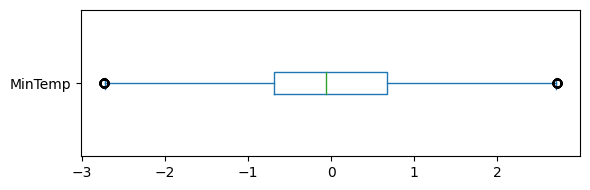

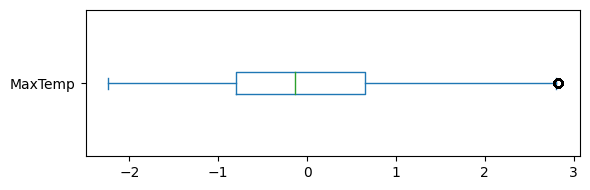

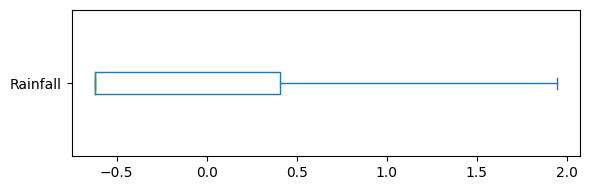

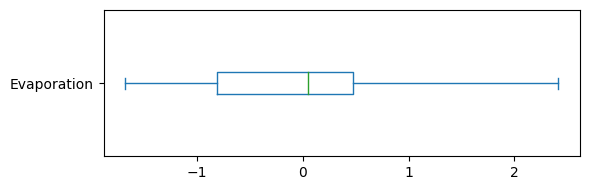

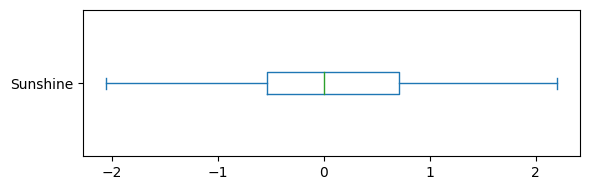

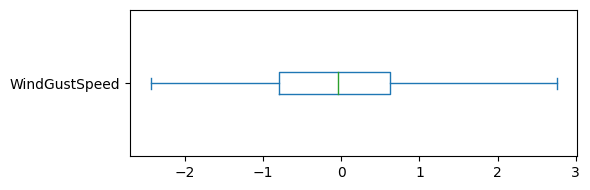

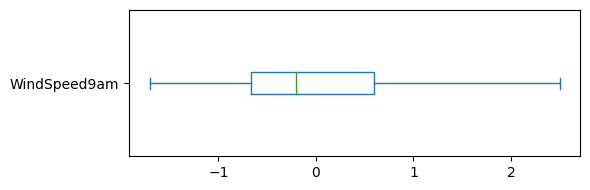

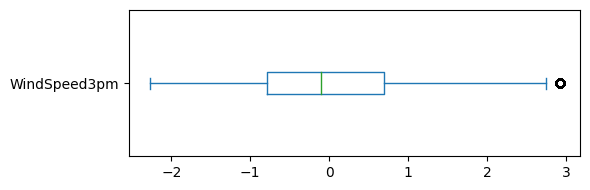

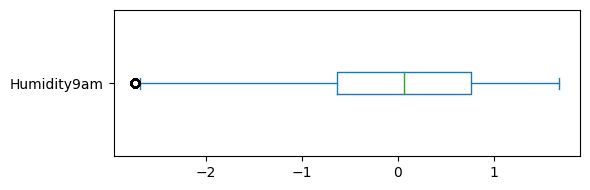

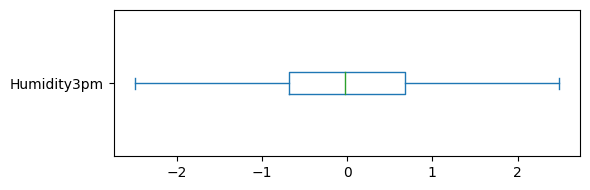

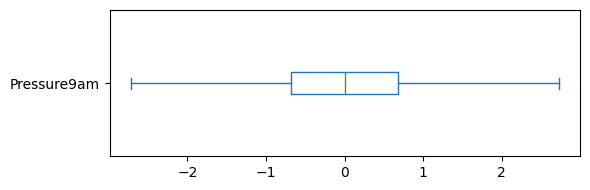

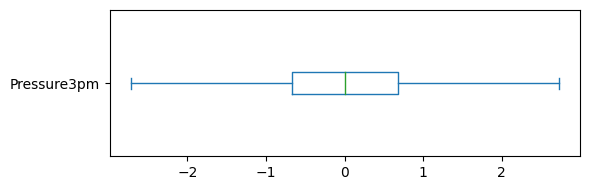

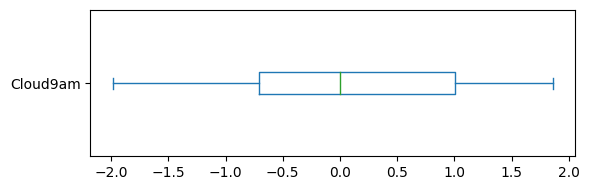

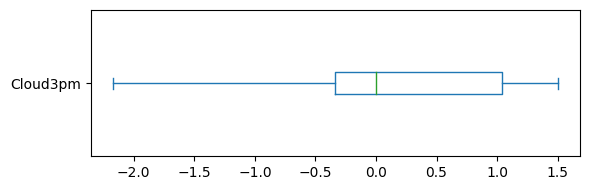

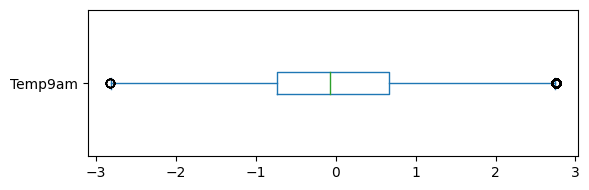

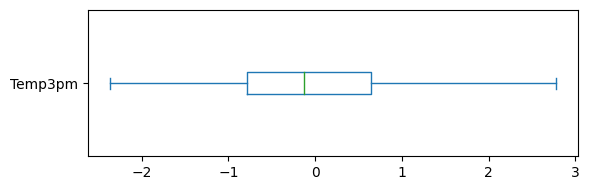

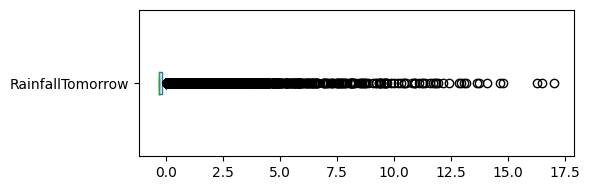

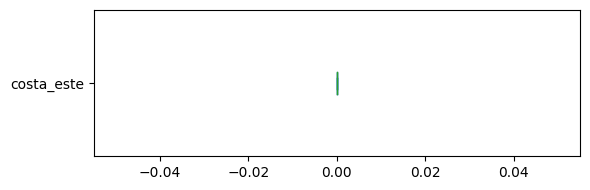

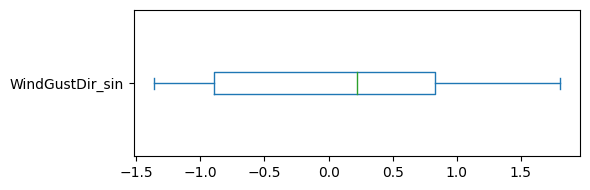

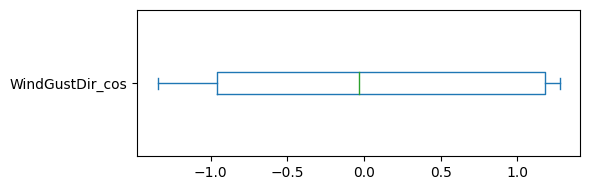

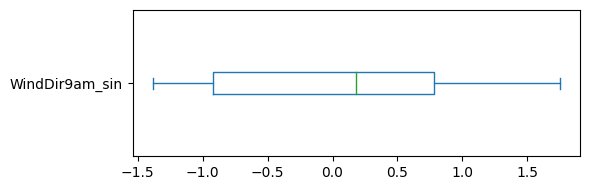

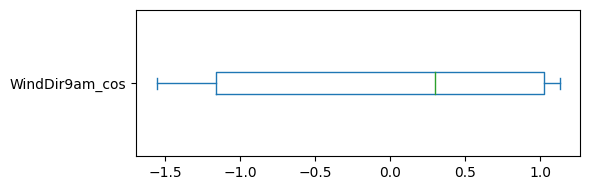

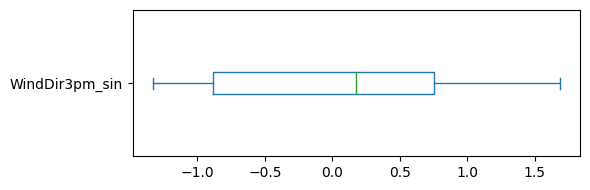

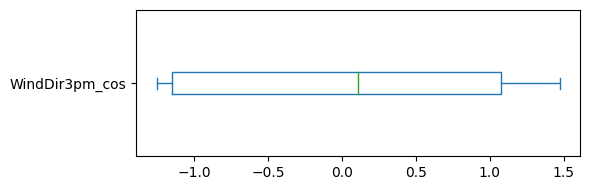

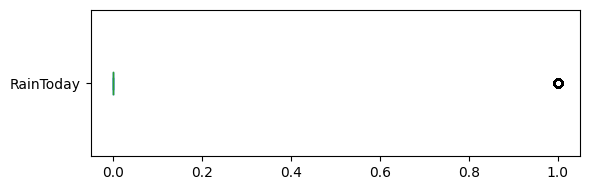

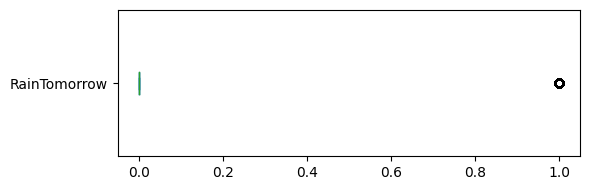

In [55]:
num_cols = df_train.select_dtypes(include=['float64']).columns.tolist()
for col in num_cols:
  plt.figure(figsize=(6, 2))
  df_train[col].plot(kind='box', vert=False)
  plt.tight_layout()
  plt.show()

# Regresiones


Modelo que predice la cantidad de lluvia para el día siguiente. "RainfallTomorrow" --> varibale continua a predecir.

In [56]:
## Con features correlacionadas >= 0.1
X_train = df_train[['RainToday', 'Humidity3pm', 'Rainfall', 'WindGustSpeed', 'Cloud9am', 'Cloud3pm', 'MinTemp', 'WindSpeed9am', 'WindSpeed3pm']]
y_train = df_train['RainfallTomorrow']

X_test = df_test[['RainToday', 'Humidity3pm', 'Rainfall', 'WindGustSpeed', 'Cloud9am', 'Cloud3pm', 'MinTemp', 'WindSpeed9am', 'WindSpeed3pm']]
y_test = df_test['RainfallTomorrow']

In [57]:
# Modelo de regresión lineal
linear_model = LinearRegression()
# Entrenamiento del modelo
linear_model.fit(X_train, y_train)
# Predicciones en el conjunto de prueba
y_pred = linear_model.predict(X_test)

# Regresión Lineal

In [58]:
# Métricas del modelo
mse_selfeat = mean_squared_error(y_test, y_pred)
r2_selfeat = r2_score(y_test, y_pred)
score_selfeat = linear_model.score(X_test, y_test)
score_selfeat_train = linear_model.score(X_train, y_train)
print(f"Puntaje train: {score_selfeat_train}")
print(f"Puntaje test: {score_selfeat}")

print(f'Error cuadrático medio (MSE) con features seleccionadas: {mse_selfeat:.2f}')
print(f'Coeficiente de determinación (R^2) con features seleccionadas: {r2_selfeat:.2f}\n')

Puntaje train: 0.17267467644601253
Puntaje test: 0.17239002139408122
Error cuadrático medio (MSE) con features seleccionadas: 0.83
Coeficiente de determinación (R^2) con features seleccionadas: 0.17



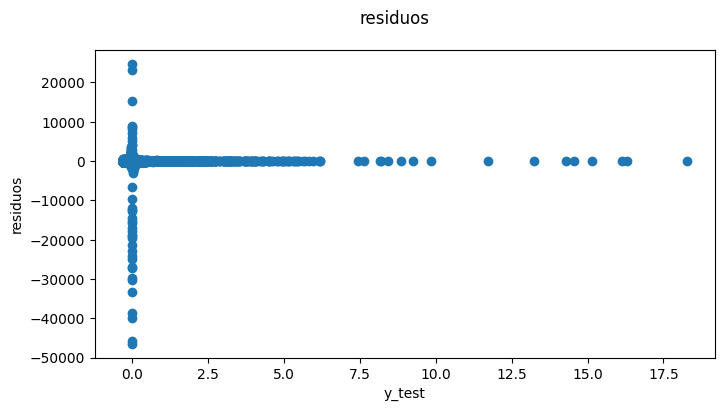

In [59]:
fig = plt.figure(figsize=(8,4))
fig.suptitle('residuos')
plt.xlabel('y_test')
plt.ylabel('residuos')
plt.scatter(y_test,100*(y_test-y_pred)/y_test)
plt.show()

El patrón nos sugiere que la función de regresión no es lineal, hay sesgo. Simplificamos el modelo para mejorar las métricas

In [60]:
# Características (X) y la variable objetivo (y)
X_train = df_train['Humidity3pm'].values.reshape(-1, 1)
y_train = df_train['RainfallTomorrow'].values

# Características (X) y la variable objetivo (y) para el conjunto de prueba
X_test = df_test[['Humidity3pm']].values.reshape(-1, 1)
y_test = df_test['RainfallTomorrow'].values

In [61]:
# Modelo de regresión lineal
linear_model = LinearRegression()
# Entrenamiento del modelo
linear_model.fit(X_train, y_train)
# Predicciones en el conjunto de prueba
y_pred = linear_model.predict(X_test)

# Métricas del modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

score_selfeat = linear_model.score(X_test, y_test)
score_selfeat_train = linear_model.score(X_train, y_train)
print(f"Puntaje train: {score_selfeat_train}")
print(f"Puntaje test: {score_selfeat}")

print(f'Error cuadrático medio (MSE): {mse:.2f}')
print(f'Coeficiente de determinación (R^2): {r2:.2f}\n')

Puntaje train: 0.11126975612788981
Puntaje test: 0.10526207579437785
Error cuadrático medio (MSE): 0.89
Coeficiente de determinación (R^2): 0.11



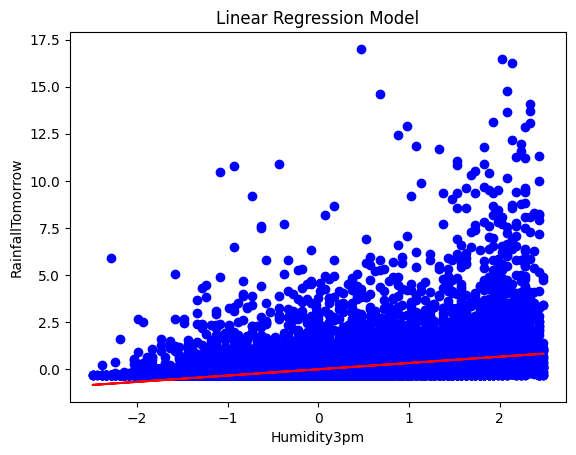

In [62]:
plt.scatter(X_train, y_train, color='blue')
plt.plot(X_train, linear_model.predict(X_train), color='red')

plt.xlabel('Humidity3pm')
plt.ylabel('RainfallTomorrow')
plt.title('Linear Regression Model')

plt.show()

## Regresión lineal con gradiente descendiente

In [63]:
## Con todas las features
X_train = df_train.drop(['RainfallTomorrow'], axis=1)
y_train = df_train['RainfallTomorrow']

X_test = df_test.drop(['RainfallTomorrow'], axis=1)
y_test = df_test['RainfallTomorrow']

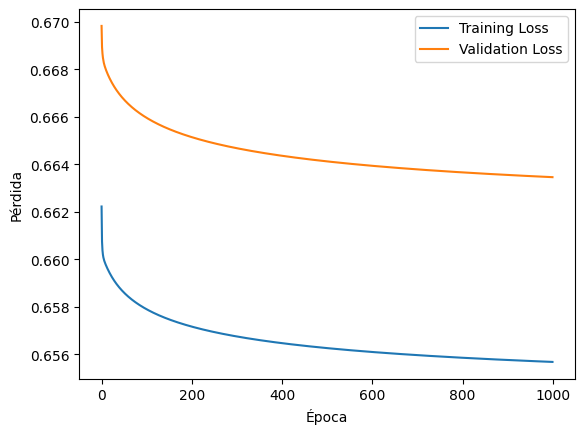

Resultados con Gradiente Descendiente:
Error cuadrático medio (MSE): 0.66
Coeficiente de determinación (R^2): 0.34


In [64]:
# Creación del modelo
model_sgd = SGDRegressor(max_iter=10000, random_state=42)

# Listas para almacenar las pérdidas
training_losses = []
validation_losses = []

# Ciclo de entrenamiento
for epoch in range(1000):  # Ajusta según el número real de épocas
    # train
    model_sgd.partial_fit(X_train, y_train)
    y_train_pred = model_sgd.predict(X_train)
    training_loss = mean_squared_error(y_train, y_train_pred)
    training_losses.append(training_loss)

    # Validación
    y_val_pred = model_sgd.predict(X_test)
    validation_loss = mean_squared_error(y_test, y_val_pred)
    validation_losses.append(validation_loss)

# Graficar las pérdidas
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.xlabel('Época')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


# Predicciones en el conjunto de prueba (Test)
y_pred_sgd = model_sgd.predict(X_test)

# Métricas del modelo
mse_sgd = mean_squared_error(y_test, y_pred_sgd)
r2_sgd = r2_score(y_test, y_pred_sgd)

# Outputs
print('Resultados con Gradiente Descendiente:')
print(f'Error cuadrático medio (MSE): {mse_sgd:.2f}')
print(f'Coeficiente de determinación (R^2): {r2_sgd:.2f}')

Hay una mejora para ambas métricas en comparación con la regresión lineal sin regularización. El R-cuadrado aumenta en unos 23 centecimas, lo que indica un mejor ajuste.

## LR con Regularización

### Lasso

In [65]:
## Con todas las features
X_train = df_train.drop(['RainfallTomorrow'], axis=1)
y_train = df_train['RainfallTomorrow']

X_test = df_test.drop(['RainfallTomorrow'], axis=1)
y_test = df_test['RainfallTomorrow']

In [66]:
modelo_lasso = make_pipeline(StandardScaler(),
                        LassoCV(
                           alphas=np.logspace(-10, 10, 200),
                           cv=10
                        )
         )

_ = modelo_lasso.fit(X_train, y_train)

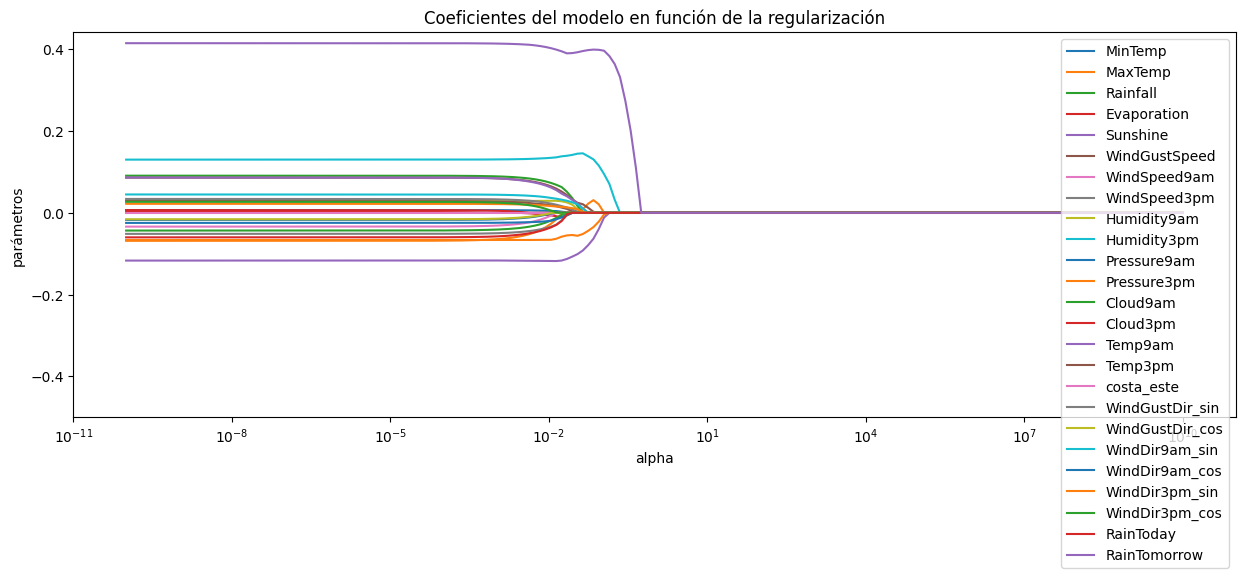

In [67]:
# Evolución de los parámetros en función de alpha
alphas = modelo_lasso.steps[1][1].alphas
coefs = []

for alpha in alphas:
    modelo_aux = make_pipeline(StandardScaler(), Lasso(alpha=alpha, tol=1))
    modelo_aux.fit(X_train, y_train)
    coefs.append(modelo_aux.steps[1][1].coef_.flatten())

fig, ax = plt.subplots(figsize=(15,5))
ax.plot(alphas, coefs, label=X_train.columns)
ax.set_xscale('log')
ax.set_ylim([-0.5,None])
ax.set_xlabel('alpha')
ax.set_ylabel('parámetros')
ax.legend()
ax.set_title('Coeficientes del modelo en función de la regularización')
plt.show()

Text(0.5, 1.0, 'Features incluidas en función de la regularización')

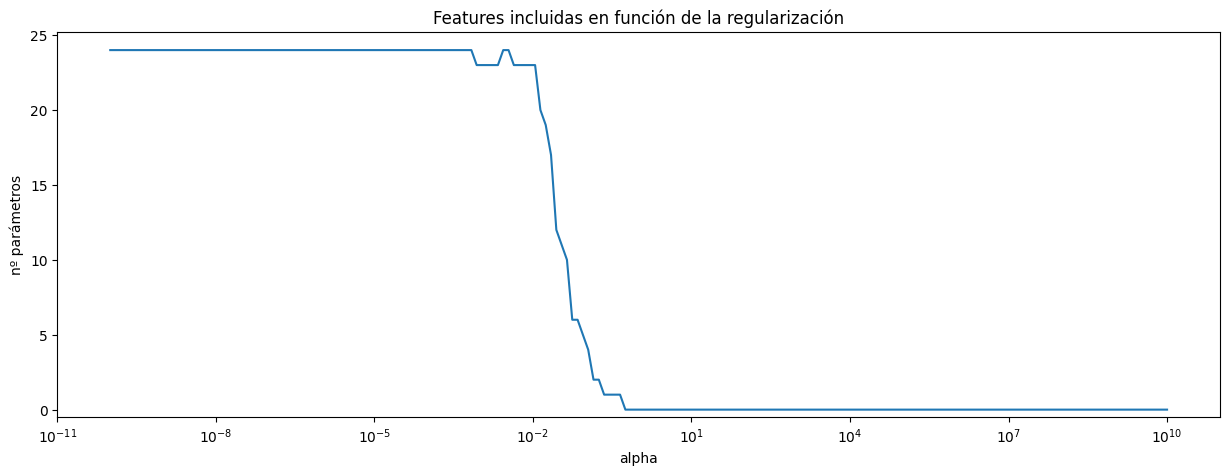

In [68]:
n_predictores = []

for alpha in alphas:
    modelo_aux = make_pipeline(StandardScaler(), Lasso(alpha=alpha, tol=1))
    modelo_aux.fit(X_train, y_train)
    coef_no_cero = np.sum(modelo_aux.steps[1][1].coef_.flatten() != 0)
    n_predictores.append(coef_no_cero)

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(alphas, n_predictores)
ax.set_xscale('log')
ax.set_ylim([-0.5,None])
ax.set_xlabel('alpha')
ax.set_ylabel('nº parámetros')
ax.set_title('Features incluidas en función de la regularización')

In [69]:
# Mejor valor alpha encontrado
mod = modelo_lasso.steps[1][1]
print(f"Mejor valor de alpha encontrado: {mod.alpha_}")

Mejor valor de alpha encontrado: 0.0003409285069746814


In [70]:
# Error de test del modelo
rmse_lasso = mean_squared_error(y_test,y_pred,squared = False)
R2_lasso = metrics.r2_score(y_test, y_pred)

print(f"El error (rmse) de test es: {rmse_lasso}")
print(f"El error (R2) de test es: {R2_lasso}")

El error (rmse) de test es: 0.945905874918653
El error (R2) de test es: 0.10526207579437785


### Ridge

In [71]:
## Con todas las features
X_train = df_train.drop(['RainfallTomorrow'], axis=1)
y_train = df_train['RainfallTomorrow']

X_test = df_test.drop(['RainfallTomorrow'], axis=1)
y_test = df_test['RainfallTomorrow']

In [72]:
modelo_ridge = make_pipeline(StandardScaler(),
                        RidgeCV(
                           alphas          = np.logspace(-10, 10, 200),
                           fit_intercept   = True,
                           store_cv_values = True
                        )
         )

_ = modelo_ridge.fit(X_train, y_train)

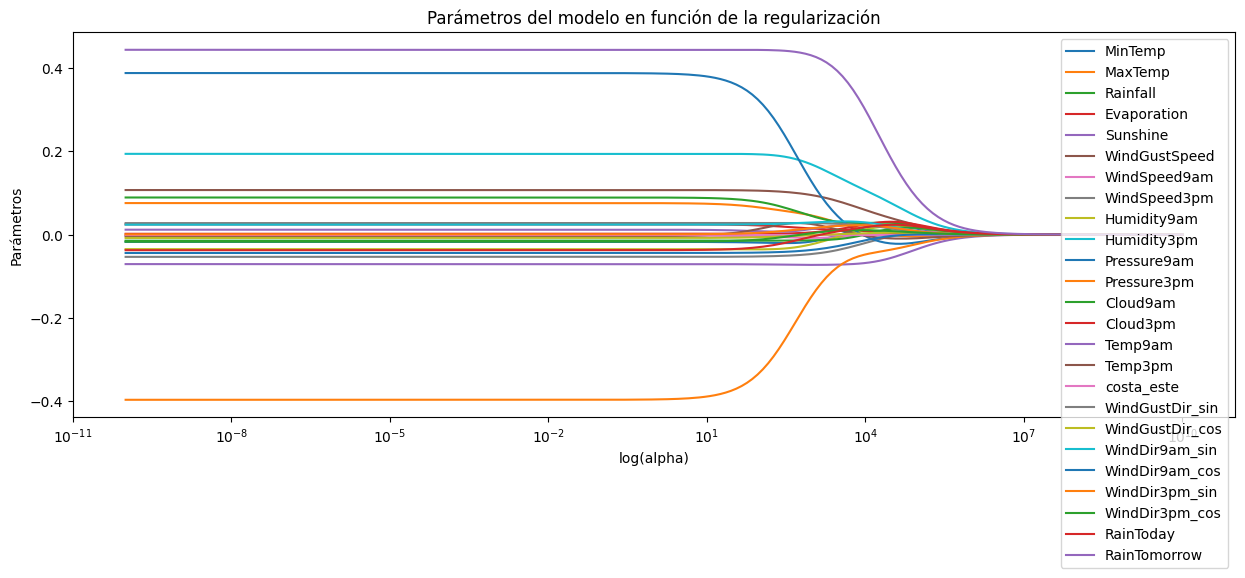

In [73]:
alphas = modelo_ridge.steps[1][1].alphas
coefs = []

for alpha in alphas:
    modelo_aux = make_pipeline(StandardScaler(), Ridge(alpha=alpha))
    modelo_aux.fit(X_train, y_train)
    coefs.append(modelo_aux.steps[1][1].coef_.flatten())

fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(alphas, coefs, label=X_train.columns)
ax.set_xscale('log')
ax.set_xlabel('log(alpha)')
ax.set_ylabel('Parámetros')
ax.set_title('Parámetros del modelo en función de la regularización');
plt.axis('tight')
plt.legend()
plt.show()

In [74]:
print(f"Mejor valor de alpha encontrado: {modelo_ridge.steps[1][1].alpha_}")

Mejor valor de alpha encontrado: 18.041864093920754


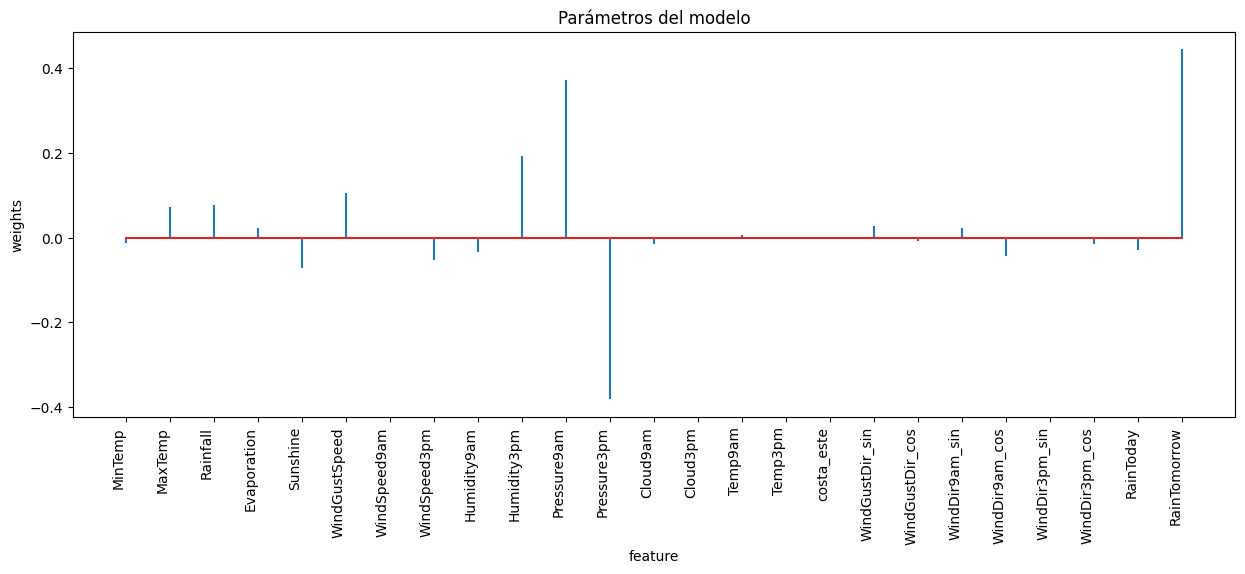

In [75]:
df_coeficientes = pd.DataFrame({'predictor': X_train.columns,'coef': mod.coef_.flatten()})

fig, ax = plt.subplots(figsize=(15,5))
ax.stem(df_coeficientes.predictor, df_coeficientes.coef, markerfmt=' ')
plt.xticks(rotation=90, ha='right', size=10)
ax.set_xlabel('feature')
ax.set_ylabel('weights')
ax.set_title('Parámetros del modelo');

In [76]:
# Predicciones test
y_pred = modelo_ridge.predict(X_test)

In [77]:
# Error de test del modelo
rmse_ridge = mean_squared_error(y_test,
                y_pred,
                squared = False
             )
R2_ridge = metrics.r2_score(y_test, y_pred)

print(f"El error (rmse) de test es: {rmse_ridge}")
print(f"El error (R) de test es: {R2_ridge}")

El error (rmse) de test es: 0.813054241486763
El error (R) de test es: 0.3389428004003847


### Elastic Net

In [78]:
## Con todas las features
X_train = df_train.drop(['RainfallTomorrow'], axis=1)
y_train = df_train['RainfallTomorrow']

X_test = df_test.drop(['RainfallTomorrow'], axis=1)
y_test = df_test['RainfallTomorrow']

In [79]:
model_elastic = ElasticNet(alpha=0.05, l1_ratio=0.5)
alpha_EN=model_elastic.get_params()['alpha']
model_elastic.fit(X_train, y_train)

ElasticNet(alpha=0.05)

In [80]:
y_pred_elastic = model_elastic.predict(X_test)

In [81]:
mse_elastic = mean_squared_error(y_test, y_pred_elastic)
r2_elastic = r2_score(y_test, y_pred_elastic)

In [82]:
print("----------")
print(f'Resultados con Regularización (Elastic Net) con alpha = {alpha_EN}')
print(f'Error cuadrático medio (MSE): {mse_elastic:.2f}')
print(f'Coeficiente de determinación (R^2): {r2_elastic:.2f}')

----------
Resultados con Regularización (Elastic Net) con alpha = 0.05
Error cuadrático medio (MSE): 0.69
Coeficiente de determinación (R^2): 0.31


In [83]:
print("Regresión Lineal:")
print("----------")
print(f'Error cuadrático medio (MSE): {mse:.2f}')
print(f'Coeficiente de determinación (R^2): {r2:.2f}\n')
print("Regresión Lineal con gradiente descendiente:")
print("----------")
print('Resultados con Gradiente Descendiente:')
print(f'Error cuadrático medio (MSE): {mse_sgd:.2f}')
print(f'Coeficiente de determinación (R^2): {r2_sgd:.2f}\n')
print("\nCon regularizaciones\n")
print('Lasso (L1):')
print("----------")
print(f"El error (rmse) de test es: {rmse_lasso}")
print(f"El error (R^2) de test es: {R2_lasso}\n")
print('Ridge (L2):')
print("----------")
print(f"El error (rmse) de test es: {rmse_ridge}")
print(f"El error (R^2) de test es: {R2_ridge}\n")
print(f'Elastic Net: alpha = {alpha_EN}')
print("----------")
print(f'Error cuadrático medio (MSE): {mse_elastic:.2f}')
print(f'Coeficiente de determinación (R^2): {r2_elastic:.2f}\n')

Regresión Lineal:
----------
Error cuadrático medio (MSE): 0.89
Coeficiente de determinación (R^2): 0.11

Regresión Lineal con gradiente descendiente:
----------
Resultados con Gradiente Descendiente:
Error cuadrático medio (MSE): 0.66
Coeficiente de determinación (R^2): 0.34


Con regularizaciones

Lasso (L1):
----------
El error (rmse) de test es: 0.945905874918653
El error (R^2) de test es: 0.10526207579437785

Ridge (L2):
----------
El error (rmse) de test es: 0.813054241486763
El error (R^2) de test es: 0.3389428004003847

Elastic Net: alpha = 0.05
----------
Error cuadrático medio (MSE): 0.69
Coeficiente de determinación (R^2): 0.31



El modelo con mejores métricas para el problema de regresión lineal es: Regresión Lineal con gradiente descendiente ya que tiene mejor R-cuadrado

# Regresion logistica sin balancear

Decidimos hacer un analísis de los modelos de regresión con los datos balanceados y no balanceados y observar si hay alguna mejora al balancear las clases

In [84]:
# Separación de variables explicativas y variables objetivo
X = df.drop(['RainTomorrow', 'RainfallTomorrow'], axis=1).copy()
y = df[['RainTomorrow']].copy()

# Spliteo mi dataset en train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((21596, 22), (5399, 22), (21596, 1), (5399, 1))

In [85]:
# Creo un Dataframe de TRAIN
df_train = pd.DataFrame(X_train, columns=X.columns)
df_train['RainTomorrow'] = y['RainTomorrow']

In [86]:
# Creo un Dataframe de TEST
df_test = pd.DataFrame(X_test, columns=X.columns)
df_test['RainTomorrow'] = y['RainTomorrow']

In [87]:
# Preproceso mi df de test y mi df de train
df_train = preprocessor.fit_transform(df_train)
df_test = preprocessor.fit_transform(df_test)

In [88]:
df_train.head()

,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,...,Temp3pm,costa_este,WindGustDir_sin,WindGustDir_cos,WindDir9am_sin,WindDir9am_cos,WindDir3pm_sin,WindDir3pm_cos,RainToday,RainTomorrow
0,-1.614673,-0.854131,-0.621439,-1.032404,3.565081e-01,2.124248,0.483020,1.718083,-0.099661,-0.329139,...,-0.846229,0.0,0.221755,1.278340,0.184330,1.131397,0.179385,1.474945,0.0,0.0
1,-0.319681,-0.056216,-0.621439,-0.457448,-2.647590e-16,0.103362,1.288428,0.236155,-0.800704,-0.680774,...,0.097866,0.0,0.827210,1.178405,0.783633,1.029065,0.755477,1.371154,0.0,0.0
2,-1.229675,-0.101381,0.199857,1.051810,1.727732e+00,1.450619,1.288428,2.174060,-0.584998,-1.132877,...,-0.072380,0.0,0.221755,1.278340,0.184330,1.131397,0.179385,1.474945,0.0,0.0
3,0.345315,-0.628306,-0.621439,0.476855,-3.291038e-01,0.926686,1.748662,1.148110,-0.854630,0.524832,...,-0.737890,0.0,1.340506,-0.962872,1.291712,-1.163554,1.243879,-0.852732,0.0,0.0
4,0.642813,0.109388,-0.621439,1.051810,5.353634e-01,-0.196029,0.598079,0.692133,-0.908557,0.122964,...,0.066913,0.0,0.221755,-1.347398,0.783633,-1.454968,0.755477,-1.148302,0.0,0.0


In [89]:
train_clasificacion_X = df_train.iloc[:, :-1]
y_train_clasificacion = df_train.iloc[:,-1]

In [90]:
x_test_clasificacion = df_test.iloc[:, :-1]
y_test_clasificacion = df_test.iloc[:,-1]

In [91]:
classifier = LogisticRegression(random_state = 0)
classifier.fit(train_clasificacion_X, y_train_clasificacion)
valor_y_predecir = classifier.predict(x_test_clasificacion)

#metricas
cm = confusion_matrix(y_test_clasificacion, valor_y_predecir)
acc_score = accuracy_score(y_test_clasificacion, valor_y_predecir)

In [92]:
probabilidades_y = classifier.predict_proba(x_test_clasificacion)[:,-1]
fpr, tpr, thresholds = roc_curve(y_test_clasificacion, probabilidades_y)
roc_auc = auc(fpr,tpr)

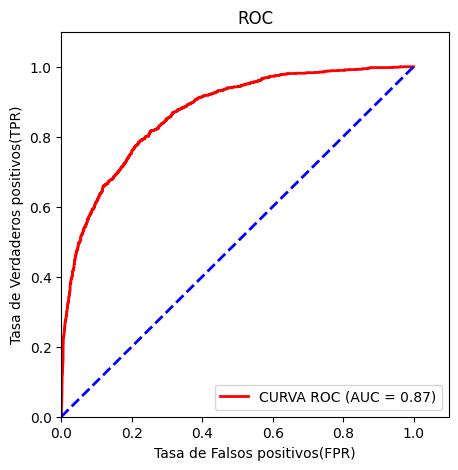

In [93]:
plt.figure(figsize=(5,5))
plt.plot(fpr, tpr, color="red", lw=2, label='CURVA ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0,1],[0,1], color="blue", lw=2, linestyle="--")
plt.xlim([0.0, 1.10])
plt.ylim([0.0, 1.10])
plt.xlabel("Tasa de Falsos positivos(FPR)")
plt.ylabel("Tasa de Verdaderos positivos(TPR)")
plt.title("ROC")
plt.legend(loc="lower right")
plt.show()

Podemos concluir que para este modelo (regresión logística) entrenado con todas las features y los datos sin balancear, tiene valor cercano a uno, lo que siginifica que el TPR (ratio de verdaderos positivos) es mas alto que el FPR (ratio de falsos positivos, es decir, predice días de no lluvia como lluvia)

# Explicabilidad con dataset no balanceado

# Explicabilidad de modelo de regresion logistica sin balancear

In [94]:
clasificacion_parametros = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['liblinear', 'lbfgs', 'saga'],
    'max_iter': [100, 200, 300],
    'class_weight': [None, 'balanced']
}

optimizar_clasificacion = RandomizedSearchCV(
    LogisticRegression(random_state=23), clasificacion_parametros
)

optimizar_clasificacion.fit(train_clasificacion_X, y_train_clasificacion)

RandomizedSearchCV(estimator=LogisticRegression(random_state=23),
                   param_distributions={'C': [0.001, 0.01, 0.1, 1, 10],
                                        'class_weight': [None, 'balanced'],
                                        'max_iter': [100, 200, 300],
                                        'penalty': ['l2'],
                                        'solver': ['liblinear', 'lbfgs',
                                                   'saga']})

# Métricas para datos NO balanceados

In [95]:
modelo_optimizado_clasificacion = optimizar_clasificacion.best_estimator_

              precision    recall  f1-score   support

         0.0       0.87      0.93      0.90      4162
         1.0       0.71      0.53      0.61      1237

    accuracy                           0.84      5399
   macro avg       0.79      0.73      0.75      5399
weighted avg       0.83      0.84      0.83      5399



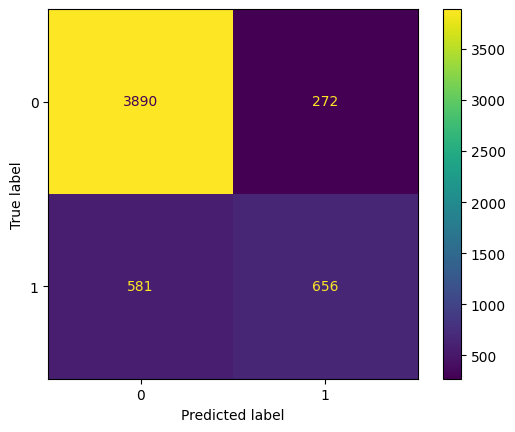

In [96]:
y_pred_clasificacion_optimizado = modelo_optimizado_clasificacion.predict(x_test_clasificacion)


print(classification_report(y_test_clasificacion, y_pred_clasificacion_optimizado))


ConfusionMatrixDisplay(
    confusion_matrix(y_test_clasificacion, y_pred_clasificacion_optimizado)
).plot()

Tiene una exactitud del 83% el modelo con los parametro optmizados con GridCV

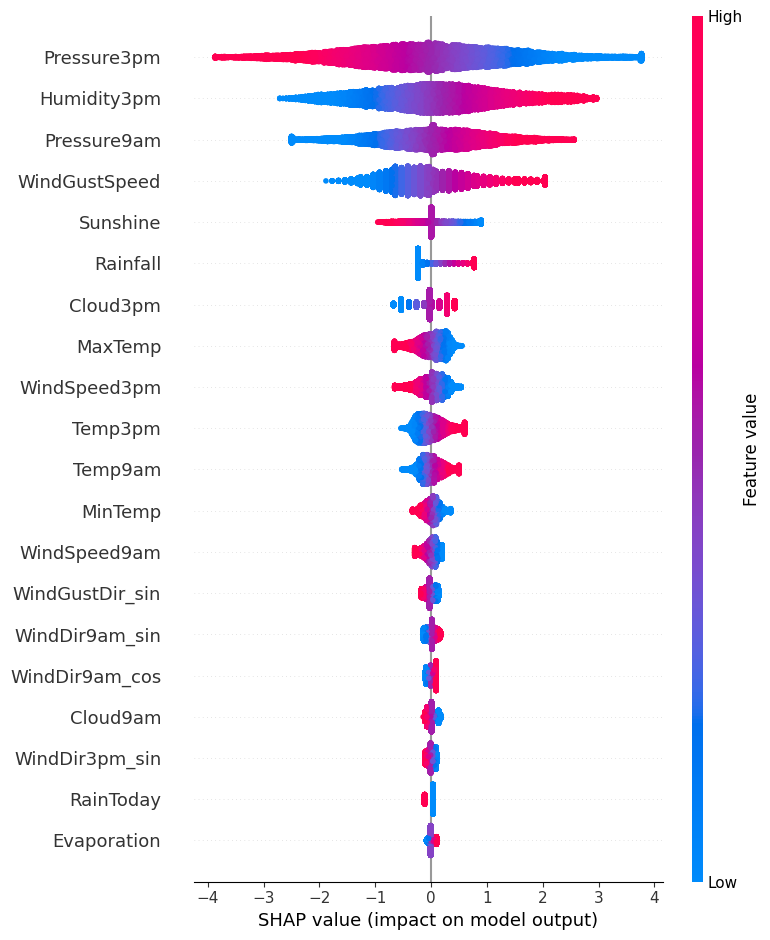

In [97]:
explicar_clasificacion = shap.LinearExplainer(
    classifier,
    train_clasificacion_X.astype("float64").copy(),
    features_names=train_clasificacion_X.columns,
)


shap_valores_clasificacion = explicar_clasificacion(
    train_clasificacion_X.astype("float64")
)

shap.summary_plot(shap_valores_clasificacion, train_clasificacion_X)

Las dos variables mas importantes para mi modelo son la Presión y la humedad de las 3pm. A menor presión mayor es el impacto en el modelo, osea es mas probable de que lo clasifique como un día de lluvia. Sin embargo con los valores de la humedad es al reves, A mayor humedad mayor es el impacto de la variable para el modelo prediga un dia de lluvia.

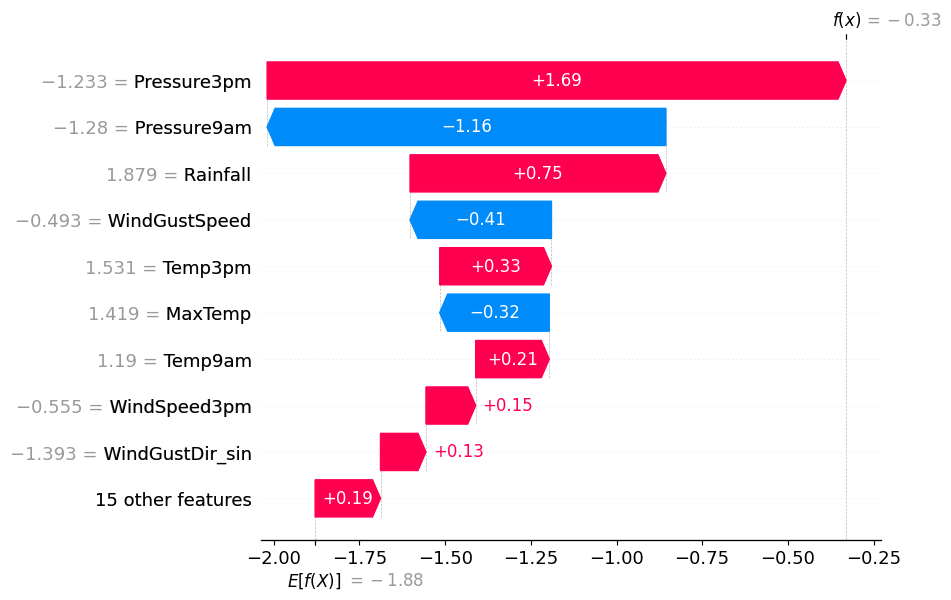

In [98]:
index = 50

classifier.predict(x_test_clasificacion)[index]

shap_valores_clasificacion = explicar_clasificacion(x_test_clasificacion)

explicacion = shap.Explanation(
    values=shap_valores_clasificacion[index],
    base_values=explicar_clasificacion.expected_value,
    feature_names=train_clasificacion_X.columns,
)


shap.plots.waterfall(explicacion)

El valor SHAP para cada variable cuantifica cuánto impacto tiene mi variable en el modelo. Por ejemplo, según el gráfico, una presion a las 3 pm de 2.47 empuja el modelo hacia predecir menos cm cúbicos de lluvia. Caso contrario para un valor de 2.5 para la variable de presión a las 9am que contribuye a que mi modelo prediga mas cantidad de lluvia. En conclusión, para este ejemplo predijo una lluvia de -1.726 cm cúbicos.

### Interpretabilidad Global

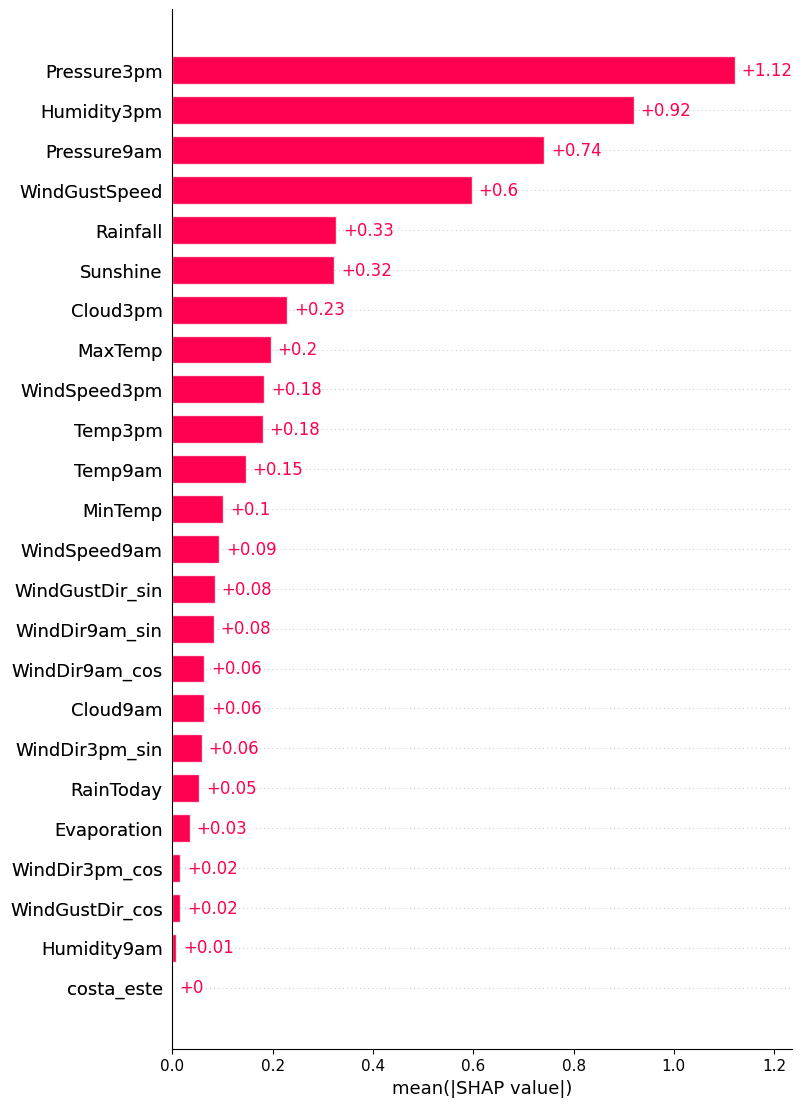

In [99]:
explicabilidad_global_clasificacion = shap.Explanation(
    shap_valores_clasificacion,
    base_values=explicar_clasificacion.expected_value,
    feature_names=train_clasificacion_X.columns,
    data=x_test_clasificacion,
)


shap.plots.bar(explicabilidad_global_clasificacion, max_display=None)

Al calcular el la media del valor absoluto del SHAP entonces obtenemos que las variables que mas impactan en nuestro modelo ya sea a predecir un dia de lluvia como uno de no lluvia son La presión de las 3pm y la humedad de las 3pm

Las variables con mayor impacto en nuestro modelo de regresión son Presion 3pm, Presion 9am y la direccion del viento mientras que para el modelo de clasificación son Presion 3pm, HUmedad 3pm y Presion 9am

# Modelo de regresión logistica balanceado

## Balanceo

In [100]:
# Modulos para el balanceo
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [101]:
def plot_balance(df):
  ### Balance de datos:
  rain_classes = pd.value_counts(df['RainTomorrow'], sort = True)
  rain_classes.plot(kind = 'bar', rot=0)
  plt.xticks(range(2))
  plt.title("Frecuencia")
  plt.xlabel("RainTomorrow")
  plt.ylabel("Cantidad")
  X_train_resampled=df.drop(['RainTomorrow'], axis=1)
  y_train_resampled=df['RainTomorrow']
  print(X_train_resampled.shape, y_train_resampled.shape)
  plt.show()

In [102]:
# Helper function for plotting ROC -- > https://towardsdatascience.com/class-imbalance-strategies-a-visual-guide-with-code-8bc8fae71e1a
def plot_roc(ax, X_train, y_train, X_test, y_test, title):
    model = LogisticRegression(random_state=42)
    model.fit(X_train, y_train)
    y_test_pred = model.predict_proba(X_test)[:,1]
    fpr, tpr, thresh = metrics.roc_curve(y_test, y_test_pred)
    auc = metrics.roc_auc_score(y_test, y_test_pred)
    ax.plot(fpr,tpr,label=f"{title} AUC={auc:.3f}")
    ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

    ax.set_title('ROC Curve')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.legend(loc=0)

(21596, 24) (21596,)


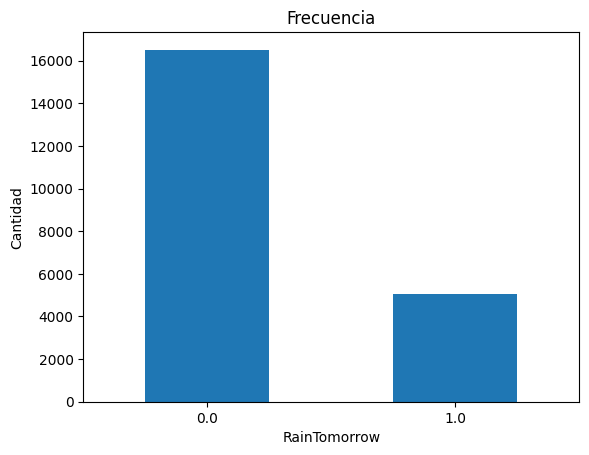

In [103]:
plot_balance(df_train)

En el gráfico de arriba se puede ver como en el dataframe original la cantidad de muestras para los dias de lluvia son mucho menor que la de los días que no llovieron.

Comparamos con AUC que técnica de balanceo de datos es mejor para la regresión logística

In [104]:
# Separación de variables explicativas y variables objetivo
X_train_balance = df_train.drop(['RainTomorrow'], axis=1).copy()
y_train_balance = df_train['RainTomorrow'].copy()

X_test_balance = df_test.drop(['RainTomorrow'], axis=1).copy()
y_test_balance = df_test['RainTomorrow'].copy()

### Subsampleo

In [105]:
rus = RandomUnderSampler(random_state=0)
X_train_rus, y_train_rus = rus.fit_resample(X_train_balance, y_train_balance)

In [106]:
df_rus = pd.DataFrame(X_train_rus, columns=X_train_balance.columns)
df_rus['RainTomorrow'] = y_train_rus

(10156, 24) (10156,)


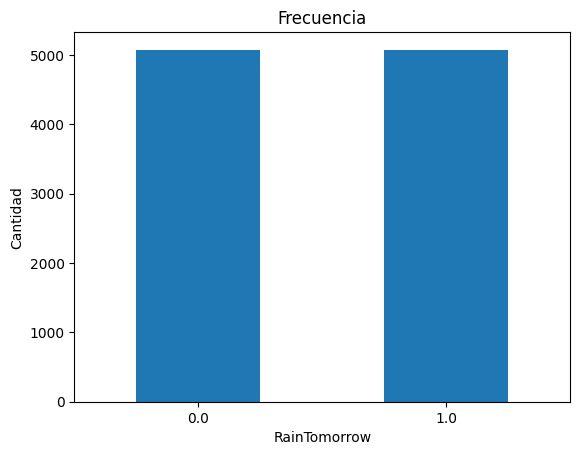

In [107]:
plot_balance(df_rus)

Ahora en total tenemos 10004 muestras distribuidas igualitariamente entre los dias que llueve y los que no

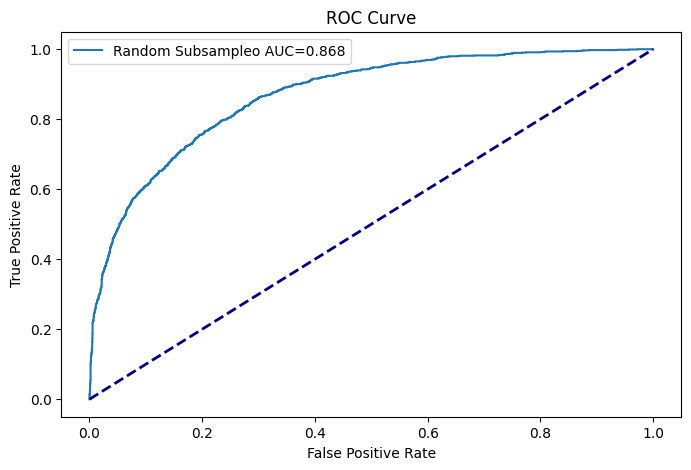

In [108]:
fig,ax1 = plt.subplots(1,1,figsize=(8,5))
plot_roc(ax1, X_train_rus, y_train_rus, X_test_balance, y_test_balance, 'Random Subsampleo')

#### - Balanceo con SMOTE

In [109]:
smote = SMOTE(random_state=0)
X_train_smote, y_train_smote = smote.fit_resample(X_train_balance, y_train_balance)

In [110]:
df_SMOTE = pd.DataFrame(X_train_smote, columns=X_train_balance.columns)
df_SMOTE['RainTomorrow'] = y_train_smote

(33036, 24) (33036,)


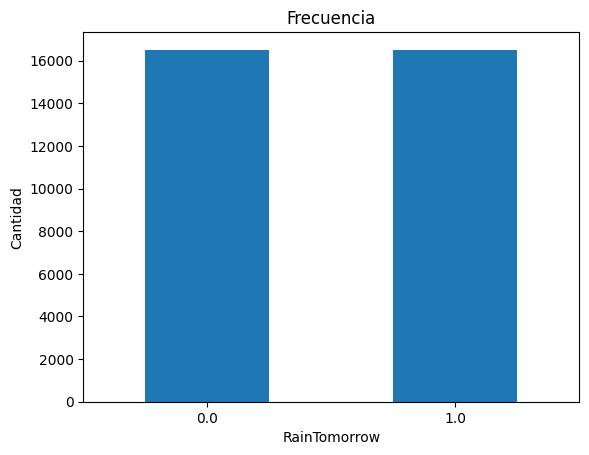

In [111]:
plot_balance(df_SMOTE)

Para esta técnica logramos tener 33176 muestras para cada clase

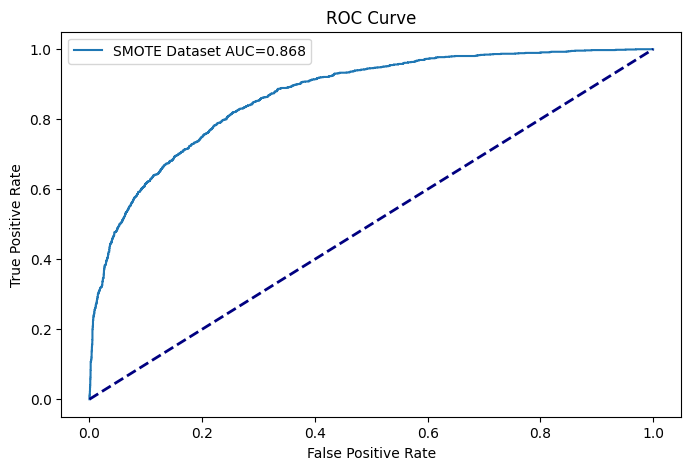

In [112]:
fig,ax1 = plt.subplots(1,1,figsize=(8,5))
plot_roc(ax1, X_train_smote, y_train_smote, X_test_balance, y_test_balance, 'SMOTE Dataset')

#### - Balanceo con SMOTE(oversampling)-TOMEK(undersampling)

Además, investigamos otras maneras de balancear el DataSet y nos encontramos con SMOTE-TOMEK. Esta técnica combina el sobresampleo con SMOTE con el subsampleo con TOMEK Link que toma dos puntos cercanos de diferentes clases y por cada par se borran aquellos que pertenezcan a la clase mayoritoria, de esa forma el límite de decisión se vuelve mas claro.

  Fuente: https://towardsdatascience.com/class-imbalance-strategies-a-visual-guide-with-code-8bc8fae71e1a

In [113]:
smotetomek = SMOTETomek(random_state=0)
X_train_smotetomek, y_train_smotetomek = smotetomek.fit_resample(X_train_balance, y_train_balance)

In [114]:
df_smotetomek = pd.DataFrame(X_train_smotetomek, columns=X_train_balance.columns)
df_smotetomek['RainTomorrow'] = y_train_smotetomek

(32878, 24) (32878,)


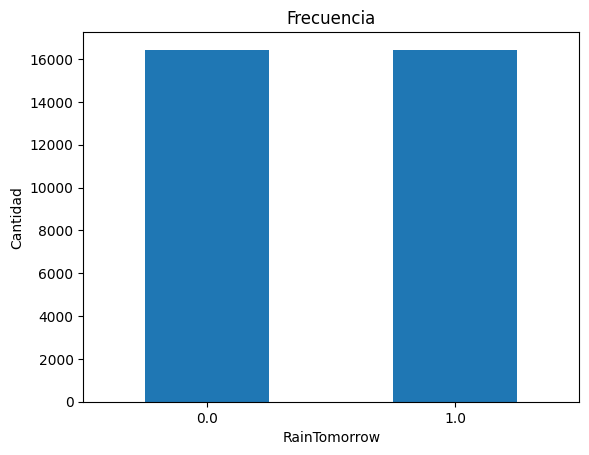

In [115]:
plot_balance(df_smotetomek)

Se logran tener 33056 muestras en total.

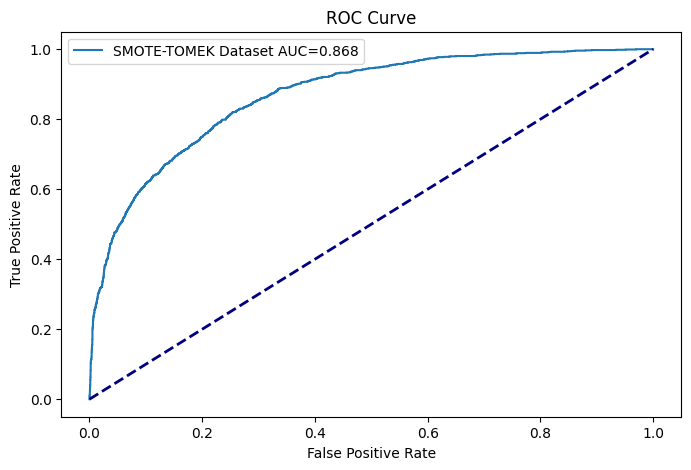

In [116]:
fig,ax1 = plt.subplots(1,1,figsize=(8,5))
plot_roc(ax1, X_train_smotetomek, y_train_smotetomek, X_test_balance, y_test_balance, 'SMOTE-TOMEK Dataset')

In [117]:
# VARIABILIDAD DE LOS DATASETS BALANCEADOS CON: Oversampling, SMOTE, SMOTE-Tomek
std_combined = pd.DataFrame([df_rus.describe().loc['std'], df_SMOTE.describe().loc['std'], df_smotetomek.describe().loc['std'], df_test.describe().loc['std']]).T
std_combined.columns = ['Undersampling', 'SMOTE', 'SMOTE-Tomek', 'Original']
std_combined

,Undersampling,SMOTE,SMOTE-Tomek,Original
MinTemp,0.978927,0.965766,0.965306,1.000093
MaxTemp,0.981204,0.980909,0.980761,1.000093
Rainfall,1.090386,1.094410,1.094932,1.000093
Evaporation,0.989511,0.970257,0.970288,1.000093
Sunshine,1.024232,1.014450,1.014686,1.000093
WindGustSpeed,1.050091,1.022165,1.021743,1.000093
WindSpeed9am,1.017726,0.994995,0.994476,1.000093
WindSpeed3pm,1.024285,1.001950,1.002234,1.000093
Humidity9am,0.981896,0.975565,0.975585,1.000093
Humidity3pm,1.053663,1.047039,1.047655,1.000093


Los tres datasets tiene una variabilidad muy similar, lo que explica porqué la performace es muy parecida. Optamos por usar el Dataset balanceado con la técnica SMOTE

# Métricas regresion logistica con datos balanceado

In [118]:
def plot_matrix_confusion(y_test, y_pred):
  # Calcular la matriz de confusión
  confusion_mat = confusion_matrix(y_test, y_pred)

  # Crear una figura y un eje para la matriz de confusión
  plt.figure(figsize=(4, 3))
  sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", linewidths=0.1, linecolor='blue', cbar=True)

  # Añadir etiquetas a los ejes y al gráfico
  plt.xlabel('Predicción')
  plt.ylabel('Verdaderos')
  plt.title('Matriz de Confusión')
  plt.xticks(np.arange(2) + 0.5, ['No', 'Sí'])
  plt.yticks(np.arange(2) + 0.5, ['No', 'Sí'])
  plt.show()

In [119]:
def train_test_with_balanced_df(df_train, df_test, model, title=None):
  """ Entrena, muestra métricas y plotea la curva AUC """
  X_train = df_train.drop(['RainTomorrow'], axis=1).copy()
  y_train = df_train['RainTomorrow'].copy()

  X_test = df_test.drop(['RainTomorrow'], axis=1).copy()
  y_test = df_test['RainTomorrow'].copy()

  my_model = model(random_state=42)
  my_model.fit(X_train, y_train)
  y_pred = my_model.predict(X_test)


  print(f"Resultados con: {model.__name__}\n")
  print(classification_report(y_test, y_pred))
  print(confusion_matrix(y_test, y_pred))

  print(f"\n\nMatriz de confusión para: {model.__name__}")
  plot_matrix_confusion(y_test, y_pred)

  fig,ax = plt.subplots(1,1,figsize=(8,5))
  y_test_pred = my_model.predict_proba(X_test)[:,1]
  fpr, tpr, thresh = metrics.roc_curve(y_test, y_test_pred)

  # Posicion del indice del umbral 0.5
  thresh_index = np.abs(thresh - 0.5).argmin()
  # Posicion del indice del umbral con valores mas cercanos a (0,1) para TPR y FPR
  optimal_index = ((1 - tpr**2) + fpr**2).argmin()


  auc = metrics.roc_auc_score(y_test, y_test_pred)
  ax.plot(fpr,tpr,label=f"Logistic Regression AUC={auc:.3f}")
  ax.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

  ax.set_title(f'{title}')
  ax.set_xlabel('False Positive Rate')
  ax.set_ylabel('True Positive Rate')
  ax.legend(loc=0)

  print(f"\n\nUmbrales:")
  print(f"Actual: {thresh[thresh_index]}")
  print(f"Optimo: {thresh[optimal_index]}")

  print(f"\n\nPuntaje para training vs test")
  print(f"Training: {my_model.score(X_train, y_train)}")
  print(f"Test: {my_model.score(X_test, y_test)}")

Resultados con: LogisticRegression

              precision    recall  f1-score   support

         0.0       0.92      0.80      0.85      4162
         1.0       0.53      0.76      0.62      1237

    accuracy                           0.79      5399
   macro avg       0.72      0.78      0.74      5399
weighted avg       0.83      0.79      0.80      5399

[[3326  836]
 [ 301  936]]


Matriz de confusión para: LogisticRegression


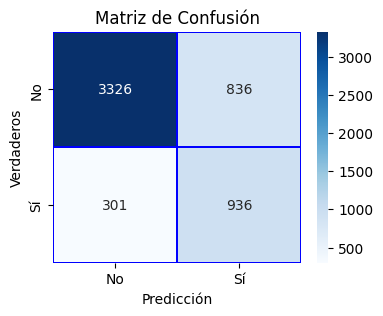



Umbrales:
Actual: 0.4999511616688792
Optimo: 0.27515189646864374


Puntaje para training vs test
Training: 0.7898779046868846
Test: 0.7894054454528616


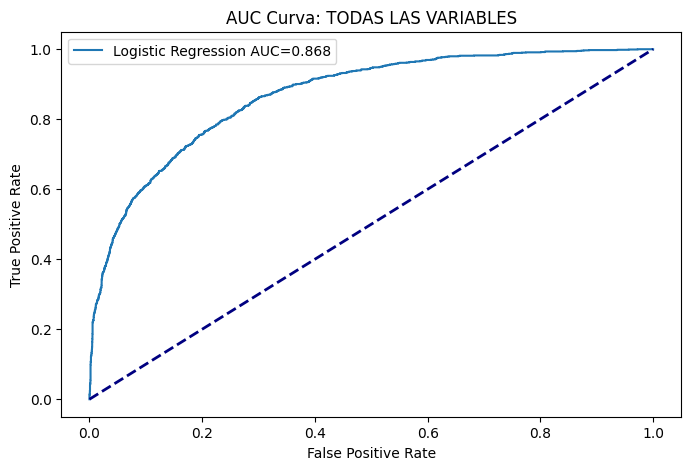

In [120]:
train_test_with_balanced_df(df_rus, df_test, LogisticRegression, "AUC Curva: TODAS LAS VARIABLES")

Un umbral de 0.5 no es óptimo para este problema, se logran mejores métricas con uno de 0.3.
Logramos un buen fitteo de los datos porque nuestro modelo performa mejor para los datos de test(0.796) que los de train (0.791)

# Modelo base Regresion Lineal

In [121]:
# Separación de variables explicativas y variables objetivo
X = df.drop(['RainfallTomorrow'], axis=1).copy()
y = df[['RainfallTomorrow']].copy()

# Spliteo mi dataset en train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((21596, 23), (5399, 23), (21596, 1), (5399, 1))

In [122]:
# Creo un Dataframe de TRAIN
df_train = pd.DataFrame(X_train, columns=X.columns)
df_train['RainfallTomorrow'] = y['RainfallTomorrow']

In [123]:
# Creo un Dataframe de TEST
df_test = pd.DataFrame(X_test, columns=X.columns)
df_test['RainfallTomorrow'] = y['RainfallTomorrow']

In [124]:
# Preproceso mi df de test y mi df de train
df_train = preprocessor.fit_transform(df_train)
df_test = preprocessor.fit_transform(df_test)

In [125]:
X_base_regresion_train = df_train[['RainToday', 'Sunshine']]
Y_base_regresion_train = df_train["RainfallTomorrow"]

In [126]:
X_base_regresion_test = df_test[['RainToday', 'Sunshine',]]
Y_base_regresion_test = df_test["RainfallTomorrow"]

In [127]:
modelo_base_regresion = LinearRegression()

In [128]:
modelo_base_regresion.fit(X_base_regresion_train, Y_base_regresion_train)

LinearRegression()

In [129]:
y_pred_base_regresion = modelo_base_regresion.predict(X_base_regresion_test)

In [130]:
def errores(y_test, y_pred):
    print("R2:   %.2f" % r2_score(y_test, y_pred))
    print("MSE:  %.2f" % mean_squared_error(y_test, y_pred))
    print("RMSE: %.2f" % sqrt(mean_squared_error(y_test, y_pred)))
    print("MAE:  %.2f" % mean_absolute_error(y_test, y_pred))
    print("MAPE: %.2f" % mean_absolute_percentage_error(y_test, y_pred))


errores(Y_base_regresion_test, y_pred_base_regresion)

R2:   0.11
MSE:  0.89
RMSE: 0.95
MAE:  0.43
MAPE: 2.11


EL modelo base (seleccionando solamente dos variables) para nuestro problema de regresión lineal tiene métricas no muy buenas, un valor MSE alejado de cero lo que indica que no es muy exacto. Un r2 muy bajo por lo que tambien indica que no explica tampoco bien la variabilidad de nuestro dataset

# Base Regresión - Importado de scikit learn

In [131]:
# https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html#sklearn-dummy-dummyclassifier
from sklearn.dummy import DummyRegressor

df_base=preprocessor.fit_transform(df)
X=df_base.drop(['RainTomorrow'], axis=1)
y=df_base['RainTomorrow']
y_reg=df_base['RainfallTomorrow']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, stratify=y, random_state=777)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_reg,test_size=0.3, stratify=y, random_state=777)

In [132]:
dummy_regr = DummyRegressor(strategy="mean")

dummy_regr.fit(X_train_reg, y_train_reg)

y_pred = dummy_regr.predict(X_test_reg)

# Metricas
mse = mean_squared_error(y_test_reg, y_pred)

r2 = r2_score(y_test_reg, y_pred)

print(f"Mean squared error: {mse}")
print(f"R-squared score: {r2}")

Mean squared error: 1.0470011761731168
R-squared score: -3.534350633316308e-05


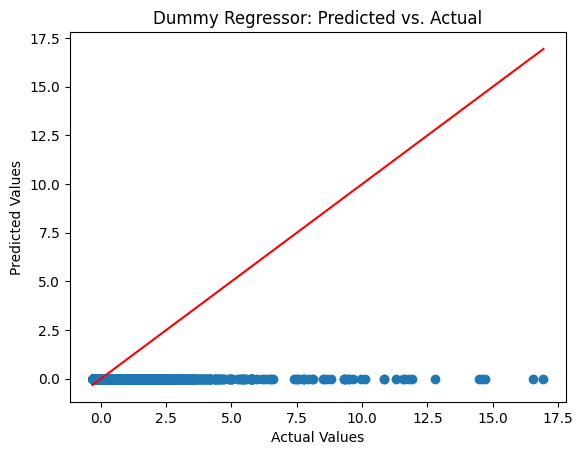

In [133]:
# Plot the predicted values against the actual values
plt.scatter(y_test_reg, y_pred)
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Dummy Regressor: Predicted vs. Actual")
# Add a diagonal line to show where the predicted values match the actual values
plt.plot([min(y_test_reg), max(y_test_reg)], [min(y_test_reg), max(y_test_reg)], color="red")

Tampoco es un buen modelo base predecir con la media de los datos, el mse para este modelo es mayor a uno y un r2 negativo indica que no explica en absoluto la variabilidad de nuestros datos

# Modelo Base clasificación

In [134]:
# Separación de variables explicativas y variables objetivo
X = df.drop(['RainTomorrow', 'RainfallTomorrow'], axis=1).copy()
y = df[['RainTomorrow']].copy()

# Spliteo mi dataset en train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((21596, 22), (5399, 22), (21596, 1), (5399, 1))

In [135]:
# Creo un Dataframe de TRAIN
df_train = pd.DataFrame(X_train, columns=X.columns)
df_train['RainTomorrow'] = y['RainTomorrow']

In [136]:
# Creo un Dataframe de TEST
df_test = pd.DataFrame(X_test, columns=X.columns)
df_test['RainTomorrow'] = y['RainTomorrow']

In [137]:
# Preproceso mi df de test y mi df de train
df_train = preprocessor.fit_transform(df_train)
df_test = preprocessor.fit_transform(df_test)

In [138]:
X_base_clasificacion_train = df_train[['MaxTemp', 'Sunshine', 'MinTemp']]
Y_base_clasificacion_train = df_train["RainTomorrow"]

In [139]:
X_base_clasificacion_test = df_test[['MaxTemp', 'Sunshine', 'MinTemp']]
Y_base_clasificacion_test = df_test["RainTomorrow"]

In [140]:
modelo_base_clasificacion = LogisticRegression()

In [141]:
modelo_base_clasificacion.fit(X_base_clasificacion_train, Y_base_clasificacion_train)

LogisticRegression()

In [142]:
y_pred_base_clasificacion = modelo_base_clasificacion.predict(X_base_clasificacion_test)

Logistica Modelo base

              precision    recall  f1-score   support

         0.0       0.82      0.93      0.87      4162
         1.0       0.56      0.29      0.39      1237

    accuracy                           0.78      5399
   macro avg       0.69      0.61      0.63      5399
weighted avg       0.76      0.78      0.76      5399



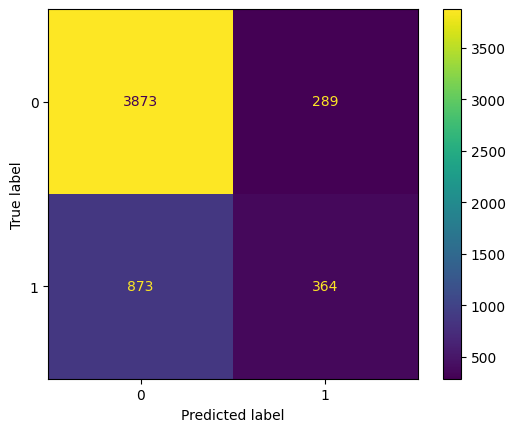

In [143]:
print("Logistica Modelo base\n")
print(classification_report(Y_base_clasificacion_test, y_pred_base_clasificacion))
ConfusionMatrixDisplay(confusion_matrix(Y_base_clasificacion_test, y_pred_base_clasificacion)).plot()



Nuestro modelo base de regresión, tiene una buena performance ya que al rededor del 78% de los datos son categorizados correctamente

# Base Clasificación - Importado de scikit learn

In [144]:
# https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html#sklearn-dummy-dummyclassifier
from sklearn.dummy import DummyClassifier


df_base=preprocessor.fit_transform(df)
X=df_base.drop(['RainTomorrow'], axis=1)
y=df_base['RainTomorrow']
y_reg=df_base['RainfallTomorrow']
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3, stratify=y, random_state=777)
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_reg,test_size=0.3, stratify=y, random_state=777)

In [145]:
# Crear un clasificador de la mayoría
dummy_clf = DummyClassifier(strategy="most_frequent")

# Entreno, aunque no es necesario porque no aprende nada
dummy_clf.fit(X_train, y_train)

# Hacer predicciones
y_pred = dummy_clf.predict(X_test)

# Score
dummy_clf.score(X_test, y_test)

# Metricas
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[6204    0]
 [1895    0]]
              precision    recall  f1-score   support

         0.0       0.77      1.00      0.87      6204
         1.0       0.00      0.00      0.00      1895

    accuracy                           0.77      8099
   macro avg       0.38      0.50      0.43      8099
weighted avg       0.59      0.77      0.66      8099



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


La presición obtenida es equivalente a predecir siempre que no lloverá, habría asertado un 76% de los casos según nuestro data set.

El cual podemos verificarlo rápidamente contando la cantidad de cada valor de la variable a predecir.  Nuestro modelo dirá todas las predicciones que NO lloverá pero éste tendra una eficiencia del 76%.


In [146]:
df_base.value_counts("RainTomorrow", normalize=True)

RainTomorrow
0.0    0.766068
1.0    0.233932
Name: proportion, dtype: float64

# Optimizacion de parametros

In [147]:
from sklearn.model_selection import GridSearchCV

### Analisis de los HP - GridCV

In [148]:
### Para cada hiperparámetro se chequean las métricas de Precisión y Recall.
scores = ["precision", "recall"]

In [149]:
def print_dataframe(filtered_cv_results):
    ### Un print bonito de los resultados de cross validation
    for mean_precision, std_precision, mean_recall, std_recall, params in zip(
        filtered_cv_results["mean_test_precision"],
        filtered_cv_results["std_test_precision"],
        filtered_cv_results["mean_test_recall"],
        filtered_cv_results["std_test_recall"],
        filtered_cv_results["params"],
    ):
        print(
            f"precision: {mean_precision:0.3f} (±{std_precision:0.03f}),"
            f" recall: {mean_recall:0.3f} (±{std_recall:0.03f}),"
            f" for {params}"
        )
    print()

In [150]:
def refit_strategy(cv_results):
    """Define the strategy to select the best estimator.

    The strategy defined here is to filter-out all results below a precision threshold
    of 0.7, rank the remaining by recall and keep all models with one standard
    deviation of the best by recall. Once these models are selected, we can select the
    fastest model to predict.

    Parameters
    ----------
    cv_results : dict of numpy (masked) ndarrays
        CV results as returned by the `GridSearchCV`.

    Returns
    -------
    best_index : int
        The index of the best estimator as it appears in `cv_results`.
    """
    # print the info about the grid-search for the different scores
    precision_threshold = 0.7

    cv_results_ = pd.DataFrame(cv_results)
    print("All grid-search results:")
    print_dataframe(cv_results_)

    # Filter-out all results below the threshold
    high_precision_cv_results = cv_results_[
        cv_results_["mean_test_precision"] > precision_threshold
    ]

    print(f"Models with a precision higher than {precision_threshold}:")
    print_dataframe(high_precision_cv_results)

    high_precision_cv_results = high_precision_cv_results[
        [
            "mean_score_time",
            "mean_test_recall",
            "std_test_recall",
            "mean_test_precision",
            "std_test_precision",
            "rank_test_recall",
            "rank_test_precision",
            "params",
        ]
    ]

    # Select the most performant models in terms of recall
    # (within 1 sigma from the best)
    best_recall_std = high_precision_cv_results["mean_test_recall"].std()
    best_recall = high_precision_cv_results["mean_test_recall"].max()
    best_recall_threshold = best_recall - best_recall_std

    high_recall_cv_results = high_precision_cv_results[
        high_precision_cv_results["mean_test_recall"] > best_recall_threshold
    ]
    print(
        "Out of the previously selected high precision models, we keep all the\n"
        "the models within one standard deviation of the highest recall model:"
    )
    print_dataframe(high_recall_cv_results)

    # From the best candidates, select the fastest model to predict
    fastest_top_recall_high_precision_index = high_recall_cv_results[
        "mean_score_time"
    ].idxmin()

    print(
        "\nThe selected final model is the fastest to predict out of the previously\n"
        "selected subset of best models based on precision and recall.\n"
        "Its scoring time is:\n\n"
        f"{high_recall_cv_results.loc[fastest_top_recall_high_precision_index]}"
    )

    return fastest_top_recall_high_precision_index

In [151]:
# Spliteo mi dataset en train-test
X_train_gs = df_test.drop(['RainTomorrow'], axis=1)
y_train_gs = df_test['RainTomorrow']

In [152]:
tuned_parameters = [
    {"class_weight": [None, 'balanced'], "C": [0.1, 1, 10,100], "solver": ['newton-cg'], "max_iter": [200, 500]}
]

grid_search = GridSearchCV(
    LogisticRegression(), tuned_parameters, scoring=scores, refit=refit_strategy
)
grid_search.fit(X_train_gs, y_train_gs)

All grid-search results:
precision: 0.734 (±0.048), recall: 0.500 (±0.031), for {'C': 0.1, 'class_weight': None, 'max_iter': 200, 'solver': 'newton-cg'}
precision: 0.734 (±0.048), recall: 0.500 (±0.031), for {'C': 0.1, 'class_weight': None, 'max_iter': 500, 'solver': 'newton-cg'}
precision: 0.525 (±0.023), recall: 0.757 (±0.036), for {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 200, 'solver': 'newton-cg'}
precision: 0.525 (±0.023), recall: 0.757 (±0.036), for {'C': 0.1, 'class_weight': 'balanced', 'max_iter': 500, 'solver': 'newton-cg'}
precision: 0.729 (±0.046), recall: 0.509 (±0.029), for {'C': 1, 'class_weight': None, 'max_iter': 200, 'solver': 'newton-cg'}
precision: 0.729 (±0.046), recall: 0.509 (±0.029), for {'C': 1, 'class_weight': None, 'max_iter': 500, 'solver': 'newton-cg'}
precision: 0.523 (±0.022), recall: 0.758 (±0.030), for {'C': 1, 'class_weight': 'balanced', 'max_iter': 200, 'solver': 'newton-cg'}
precision: 0.523 (±0.022), recall: 0.758 (±0.030), for {'C': 1, 'cl

GridSearchCV(estimator=LogisticRegression(),
             param_grid=[{'C': [0.1, 1, 10, 100],
                          'class_weight': [None, 'balanced'],
                          'max_iter': [200, 500], 'solver': ['newton-cg']}],
             refit=<function refit_strategy at 0x78d468d87ac0>,
             scoring=['precision', 'recall'])

In [153]:
grid_search.best_params_

{'C': 1, 'class_weight': None, 'max_iter': 200, 'solver': 'newton-cg'}

In [154]:
y_pred = grid_search.predict(df_test.drop(['RainTomorrow'], axis=1))
print(classification_report(df_test['RainTomorrow'], y_pred))

              precision    recall  f1-score   support

         0.0       0.87      0.94      0.90      4162
         1.0       0.73      0.51      0.60      1237

    accuracy                           0.85      5399
   macro avg       0.80      0.73      0.75      5399
weighted avg       0.84      0.85      0.84      5399



Con la optimización de hiperparámetros usando gridcv, nos muestra que los mejores hiperparametros para nuestro modelo de regresión logística con buen score de precision y recall son los siguentes:
<br>
No hace falta que el data set esté balanceado, converge en 200 iteraciones y con un valor de regularización bajo|.

Por default en LogisticRegression de scikit-learn por default usa un valor
C= 1.0
ClassWeight=None, que no es optimizado
max_iter=100
y seteamos el solver para que solo pruebe con newton-cg pero por default usa 'lbfgs'

# Validación Cruzada

Consideramos necesario usar validación cruzada para evaluar mejor la performance del modelo con los mejores parametros

In [155]:
classification = LogisticRegression(C=10, class_weight='balanced', max_iter=500, solver='newton-cg')

In [156]:
df_test_cv = pd.concat([df_test, df_train], ignore_index=True)

X_cv, y_cv = df_test_cv.drop(['RainTomorrow'], axis=1), df_test_cv['RainTomorrow']

In [157]:
scores = cross_val_score(classification, X_cv, y_cv, cv=KFold(n_splits=5, shuffle=True, random_state=42))
scores

array([0.79774032, 0.80440822, 0.79736988, 0.78292276, 0.79885164])

In [158]:
cv_strategies = [
    ("KFold", KFold(n_splits=5, shuffle=True, random_state=42))
]

results = {}
for name, cv in cv_strategies:
    scores = cross_val_score(classification, X_cv, y_cv, cv=cv)
    results[name] = scores

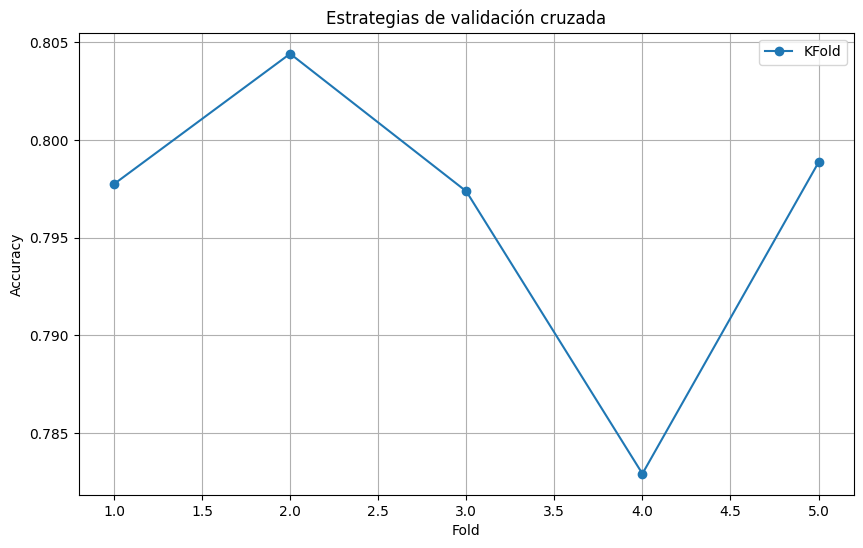

In [159]:
plt.figure(figsize=(10, 6))
for name, scores in results.items():
    plt.plot(range(1, len(scores) + 1), scores, marker='o', label=name)

plt.xlabel("Fold")
plt.ylabel("Accuracy")
plt.title("Estrategias de validación cruzada")
plt.legend()
plt.grid(True)
plt.show()

En k-folds, los scores no varían demasiado por lo que indica que nuestro modelo tiene robustez

# Redes Neuronales

## Redes Neuronales -- Regresión

In [160]:
# Dropeo valores nulos de 'RainfallTomorrow' de mi dataframe original
df.dropna(subset=['RainToday', 'RainTomorrow'], inplace=True)

# Separación de variables explicativas y variables objetivo
X = df.drop(['RainfallTomorrow'], axis=1).copy()
y = df[['RainfallTomorrow']].copy()

# Spliteo mi dataset en train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((21596, 23), (5399, 23), (21596, 1), (5399, 1))

In [183]:
# DF train
df_train = pd.DataFrame(X_train, columns=X.columns)
df_train['RainfallTomorrow'] = y['RainfallTomorrow']

# DF test
df_test = pd.DataFrame(X_test, columns=X.columns)
df_test['RainfallTomorrow'] = y['RainfallTomorrow']

# Preproceso mi df de test y mi df de train
df_train = preprocessor.fit_transform(df_train)
df_test = preprocessor.fit_transform(df_test)

In [184]:
X_train_regresion = df_train.drop(['RainfallTomorrow', 'RainTomorrow'], axis=1)
y_train_regresion = df_train['RainfallTomorrow']

X_test_regresion = df_test.drop(['RainfallTomorrow', 'RainTomorrow'], axis=1)
y_test_regresion = df_test['RainfallTomorrow']

In [163]:
def objective_reg(trial: Trial):

    # Creamos el modelo
    model = Sequential()

    # Definimos HP a optimizar
    num_layers = trial.suggest_int('num_layers', 1, 5)
    num_units_input = trial.suggest_int('n_units_input', 4, 128)
    model.add(Dense(num_units_input, activation='relu', input_shape=(X_train_regresion.shape[1],)))

    for i in range(num_layers):
        num_units = trial.suggest_int(f'n_units_layer_{i}', 4, 128)
        model.add(Dense(num_units, activation='relu'))
        dropout_rate = trial.suggest_float(f'dropout_rate_layer_{i}', 0.0, 0.5)
        model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='linear'))  # Capa final para la regresión

    # Compilamos el modelo
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-1, log=True)
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error')

    # Split train, val test
    X_train, X_valid, y_train, y_valid = train_test_split(X_train_regresion, y_train_regresion, test_size=0.2, random_state=42)

    # Entrenamos el modelo
    model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10, batch_size=64, verbose=0)

    # Evaluamos el modelo
    score = model.evaluate(X_valid, y_valid, verbose=0)
    return score

In [190]:
def create_neural_network():
    model = Sequential()

    # Input layer
    model.add(Dense(64, activation='relu', input_shape=(X_train_regresion.shape[1],)))

    # Hidden layers
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))

    # Output layer
    model.add(Dense(1, activation='linear'))

    model.compile(optimizer=Adam(learning_rate=0.01), loss='mean_squared_error')

    return model

# Red Neuronal sin optimizar hiperparámetros

In [234]:
model = create_neural_network()
model.fit(X_train_regresion, y_train_regresion, epochs=10, batch_size=64, verbose=0)

y_pred = model.predict(X_test_regresion)
mse_nn = mean_squared_error(y_test_regresion, y_pred)
print(f'MSE: {mse_nn}')

169/169 [==============================] - 0s 2ms/step
MSE: 0.6517813053398711


# Red Neuronal Optimizada

In [238]:
study = optuna.create_study(direction='minimize')  # Minimizar la pérdida
study.optimize(objective_reg, n_trials=10)

[I 2024-06-24 01:51:09,649] A new study created in memory with name: no-name-43fb007d-3c59-4e2e-a62c-005aef2573f9
[I 2024-06-24 01:51:22,450] Trial 0 finished with value: 1.090991497039795 and parameters: {'num_layers': 1, 'n_units_input': 48, 'n_units_layer_0': 34, 'dropout_rate_layer_0': 0.49596881961225175, 'learning_rate': 0.05153757431391878}. Best is trial 0 with value: 1.090991497039795.
[I 2024-06-24 01:51:41,199] Trial 1 finished with value: 0.8889706134796143 and parameters: {'num_layers': 5, 'n_units_input': 57, 'n_units_layer_0': 46, 'dropout_rate_layer_0': 0.14390798077587175, 'n_units_layer_1': 17, 'dropout_rate_layer_1': 0.49545440255615203, 'n_units_layer_2': 97, 'dropout_rate_layer_2': 0.4415587336361341, 'n_units_layer_3': 23, 'dropout_rate_layer_3': 0.3495881320130653, 'n_units_layer_4': 37, 'dropout_rate_layer_4': 0.19780810400264065, 'learning_rate': 0.00042981692532947447}. Best is trial 1 with value: 0.8889706134796143.
[I 2024-06-24 01:52:04,122] Trial 2 finishe

In [239]:
best_params = study.best_params
print("Best parameters:", best_params)

Best parameters: {'num_layers': 2, 'n_units_input': 122, 'n_units_layer_0': 96, 'dropout_rate_layer_0': 0.08651876894655736, 'n_units_layer_1': 79, 'dropout_rate_layer_1': 0.07390560086455777, 'learning_rate': 0.0005909024131407285}


In [240]:
# Entrenamos el modelo
best_model = Sequential()
best_model.add(Dense(best_params['n_units_input'], activation='relu', input_shape=(X_train_regresion.shape[1],)))


for i in range(best_params['num_layers']):
    best_model.add(Dense(best_params[f'n_units_layer_{i}'], activation='relu'))
    best_model.add(Dropout(best_params[f'dropout_rate_layer_{i}']))

best_model.add(Dense(1, activation='linear'))

In [241]:
best_model.compile(optimizer=Adam(learning_rate=best_params['learning_rate']), loss='mean_squared_error')

In [242]:
# Entrenamos el MEJOR modelo
best_model.fit(X_train_regresion, y_train_regresion, epochs=10, batch_size=64, verbose=0)

In [243]:
# Evaluamos el MEJOR modelo
train_scores = best_model.evaluate(X_train_regresion, y_train_regresion, verbose=0)
valid_scores = best_model.evaluate(X_test_regresion, y_test_regresion, verbose=0)

train_r2 = r2_score(y_train_regresion, best_model.predict(X_train_regresion))
valid_r2 = r2_score(y_test_regresion, best_model.predict(X_test_regresion))

train_mse = mean_squared_error(y_train_regresion, best_model.predict(X_train_regresion))
valid_mse = mean_squared_error(y_test_regresion, best_model.predict(X_test_regresion))

169/169 [==============================] - 0s 2ms/step


In [244]:
# Chequeamos sus métricas
print(f"Train R2: {train_r2}, Test R2: {valid_r2}")
print(f"Train MSE: {train_mse}, Test MSE: {valid_mse}")

Train R2: 0.5049538740044788, Test R2: 0.3782604425058246
Train MSE: 0.49504612599552117, Test MSE: 0.6217395574941756


El valor de r2 no es muy cercano a uno, en general explica alrededor del 35% de la variabilidad en los datos de entrenamiento y prueba.

Comparando el MSE de la red neuronal sin los parametros optmizados contra la red neuronal con los hp optmizados:

| métrica | NN Opt HP | NN |
|---------|-----------|----|
| MSE | 0.62 | 0.66 |

Tiene mejor MSE la NN con los hiperparametros optimizados


En comparación con el mejor modelo de regresión lineal que fue con gradiente descendiente, la red neuronal ajusta mejor a los datos

# Explicabilidad - NN Regresión

In [172]:
X_train_regresion = X_train_regresion.sample(frac=.25, random_state=123)
X_test_regresion = X_test_regresion.sample(frac=.25, random_state=123)

In [173]:
explainer = shap.Explainer(best_model,
                            X_train_regresion.values,
                            feature_names=X_train_regresion.columns)

explanation = explainer(X_test_regresion)

PermutationExplainer explainer: 1351it [01:11, 17.53it/s]


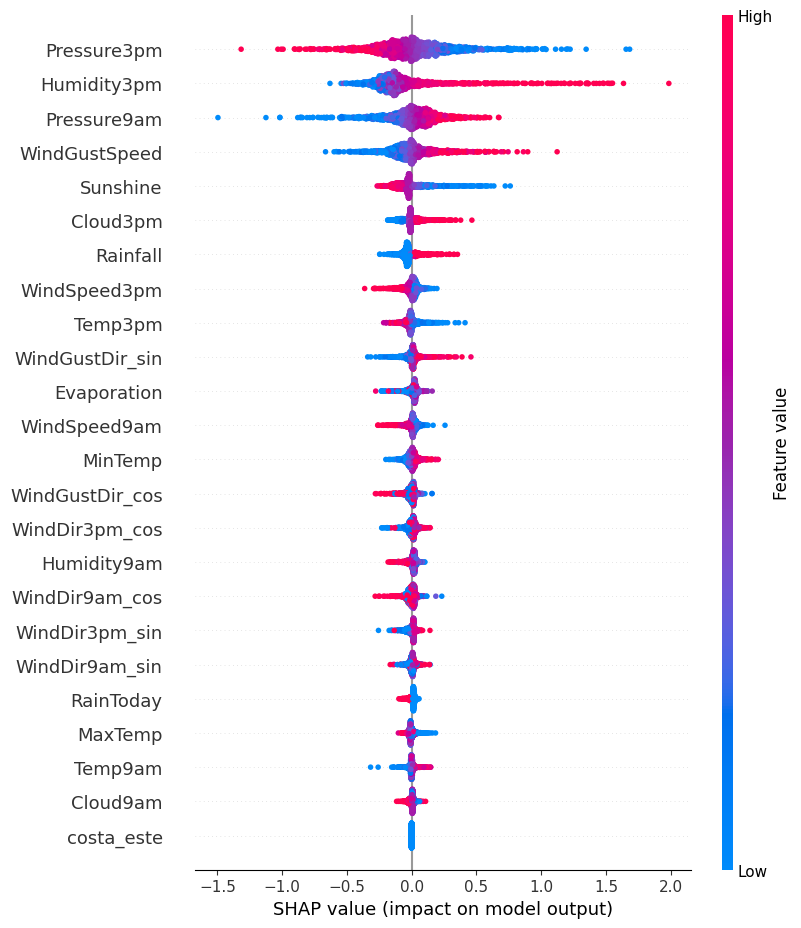

In [174]:
# Prevenir error de dimensiones, porque explica ambas clases: https://stackoverflow.com/questions/73605032/error-in-shap-plots-tree-explainer-when-using-sklearn-pipeline-for-classificat
shap.plots.beeswarm(explanation, max_display=None)

Para las redes neuronales, las variables mas explicativas son La humedad de las 3pm, La presion de las 3pm y la presion de las 9am. Tanto la presión como la humedad, a mayor valor mayor es la cantidad de lluvia que predice mi modelo. En cambio para la presion de las 3pm a mayor valor, en el modelo resta la cantidad de lluvia. Esto lo concluimos con los resultado de la primera vez que creamos la red.

## Explicabilidad local NN Regresión

In [175]:
x_train_array = X_train_regresion.sample(150)
x_test_array = X_test_regresion.sample(150)

In [176]:
explainer = shap.KernelExplainer(best_model, shap.sample(x_train_array,90))

In [192]:
muestra = x_test_array.iloc[0:1].values
shap_values = explainer.shap_values(muestra)

base_value = explainer.expected_value

pr_proba = best_model.predict(x_test_array)[0]
result = np.argmax(pr_proba[0])

  0%|          | 0/1 [00:00<?, ?it/s]

5/5 [==============================] - 0s 4ms/step


In [194]:
shap_values.shape, base_value.shape

((1, 24, 1), (1,))

In [ ]:
explanation = shap.Explanation(shap_values, base_value)
shap.summary_plot(explanation, x_test_array, feature_names=X_train_regresion.columns)
shap.plots.bar(explanation)

Conclusión: Al comparar los valores de MSE, para el problema de regresión, el mejor modelo es el de Redes Neuronales con los hiperparámetros optimizados. Anteriormente el mejor modelo había sido el de Regresión Lineal con gradiente descendiente con un valor de MSE igual a 0.76 mientra que el de las NN es igual a 0.62

## Redes Neuronales -- Clasificación

In [197]:
# Dropeo valores nulos de 'RainfallTomorrow' de mi dataframe original
df.dropna(subset=['RainToday', 'RainTomorrow'], inplace=True)

# Separación de variables explicativas y variables objetivo
X = df.drop(['RainfallTomorrow', 'RainTomorrow'], axis=1).copy()
y = df[['RainTomorrow']].copy()

# Spliteo mi dataset en train-test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((21596, 22), (5399, 22), (21596, 1), (5399, 1))

In [212]:
# DF train
df_train = pd.DataFrame(X_train, columns=X.columns)
df_train['RainTomorrow'] = y['RainTomorrow']

# DF test
df_test = pd.DataFrame(X_test, columns=X.columns)
df_test['RainTomorrow'] = y['RainTomorrow']

# Preproceso mi df de test y mi df de train
df_train = preprocessor.fit_transform(df_train)
df_test = preprocessor.fit_transform(df_test)

In [213]:
X_train_clasificacion  = df_train.drop('RainTomorrow', axis=1)
y_train_clasificacion  = df_train['RainTomorrow']

X_test_clasificacion  = df_test.drop('RainTomorrow', axis=1)
y_test_clasificacion  = df_test['RainTomorrow']

In [215]:
def objective_class(trial: Trial):
    # Create the model
    model = Sequential()
    num_layers = trial.suggest_int('num_layers', 1, 5)

    for i in range(num_layers):
        num_units = trial.suggest_int(f'n_units_layer_{i}', 4, 128)
        model.add(Dense(num_units, activation='relu'))
        dropout_rate = trial.suggest_float(f'dropout_rate_layer_{i}', 0.0, 0.5)
        model.add(Dropout(dropout_rate))


    model.add(Dense(2, activation='sigmoid'))  # Output layer for multi-class classification

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[Precision()])

    # Split test, val, train
    X_train, X_valid, y_train, y_valid = train_test_split(X_train_clasificacion, y_train_clasificacion, test_size=0.2, random_state=42)


    # Convertir etiquetas a one-hot encoding
    label_encoder = LabelEncoder()
    y_train = to_categorical(label_encoder.fit_transform(y_train))
    y_valid = to_categorical(label_encoder.transform(y_valid))

    # Entreno
    model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=5, batch_size=64, verbose=0)

    # Fitteo
    score = model.evaluate(X_valid, y_valid, verbose=0)
    return score[1]  # Devuelve precision

In [201]:
# Otimizacion de HP
study = optuna.create_study(direction='maximize')  # Minimizar la pérdida
study.optimize(objective_class, n_trials=10)

[I 2024-06-24 01:34:03,225] A new study created in memory with name: no-name-c4ae4ef8-fc4b-45d4-af04-f5b7160530e1
[I 2024-06-24 01:34:12,916] Trial 0 finished with value: 0.8479166626930237 and parameters: {'num_layers': 4, 'n_units_layer_0': 92, 'dropout_rate_layer_0': 0.1076044275868569, 'n_units_layer_1': 78, 'dropout_rate_layer_1': 0.26789531300519653, 'n_units_layer_2': 17, 'dropout_rate_layer_2': 0.2554059983888595, 'n_units_layer_3': 36, 'dropout_rate_layer_3': 0.14780502676036533}. Best is trial 0 with value: 0.8479166626930237.
[I 2024-06-24 01:34:20,098] Trial 1 finished with value: 0.8432457447052002 and parameters: {'num_layers': 2, 'n_units_layer_0': 37, 'dropout_rate_layer_0': 0.27337721936893367, 'n_units_layer_1': 15, 'dropout_rate_layer_1': 0.34659343843030044}. Best is trial 0 with value: 0.8479166626930237.
[I 2024-06-24 01:34:28,583] Trial 2 finished with value: 0.8444444537162781 and parameters: {'num_layers': 3, 'n_units_layer_0': 34, 'dropout_rate_layer_0': 0.351

In [202]:
# Obtenemos los mejores parametros
best_params = study.best_params
print("Best parameters:", best_params)

Best parameters: {'num_layers': 3, 'n_units_layer_0': 126, 'dropout_rate_layer_0': 0.40932360748922586, 'n_units_layer_1': 128, 'dropout_rate_layer_1': 0.09023954584057148, 'n_units_layer_2': 108, 'dropout_rate_layer_2': 0.07103652639199409}


In [216]:
best_model = Sequential()
best_model.add(Dense(2, activation='relu', input_shape=(X_train_clasificacion.shape[1],)))

for i in range(best_params['num_layers']):
    best_model.add(Dense(best_params[f'n_units_layer_{i}'], activation='relu'))
    best_model.add(Dropout(best_params[f'dropout_rate_layer_{i}']))

best_model.add(Dense(2, activation='softmax'))

In [217]:
best_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[Precision()])

In [218]:
label_encoder = LabelEncoder()
y_train_clasificacion = to_categorical(label_encoder.fit_transform(y_train_clasificacion))
y_test_clasificacion = to_categorical(label_encoder.transform(y_test_clasificacion))

In [222]:
# Entrenamos
best_model.fit(X_train_clasificacion, y_train_clasificacion, epochs=20, batch_size=64, verbose=0)

In [223]:
# Evaluamos
train_scores = best_model.evaluate(X_train_clasificacion, y_train_clasificacion, verbose=0)
valid_scores = best_model.evaluate(X_test_clasificacion, y_test_clasificacion, verbose=0)

train_preds = np.argmax(best_model.predict(X_train_clasificacion), axis=1)
valid_preds = np.argmax(best_model.predict(X_test_clasificacion), axis=1)

train_labels = np.argmax(y_train_clasificacion, axis=1)
valid_labels = np.argmax(y_test_clasificacion, axis=1)

train_precision = precision_score(train_labels, train_preds)
valid_precision = precision_score(valid_labels, valid_preds)

169/169 [==============================] - 0s 3ms/step


In [208]:
# Metricas
print(f"Train Precision: {train_accuracy}, Validation Precision: {valid_accuracy}")

Train Accuracy: 0.844461937395814, Validation Accuracy: 0.8399703648823856


In [224]:
if len(y_test_clasificacion.shape) > 1 and y_test_clasificacion.shape[1] > 1:
    y_test_clasificacion = np.argmax(y_test_clasificacion, axis=1)

In [225]:
predictions_prob = best_model.predict(X_test_clasificacion)

predictions = (predictions_prob > 0.5).astype('int32')  # Convertir probabilidades a etiquetas binarias
if len(predictions.shape) > 1 and predictions.shape[1] > 1:
    predictions = np.argmax(predictions, axis=1)

conf_matrix = confusion_matrix(y_test_clasificacion, predictions)

169/169 [==============================] - 0s 2ms/step


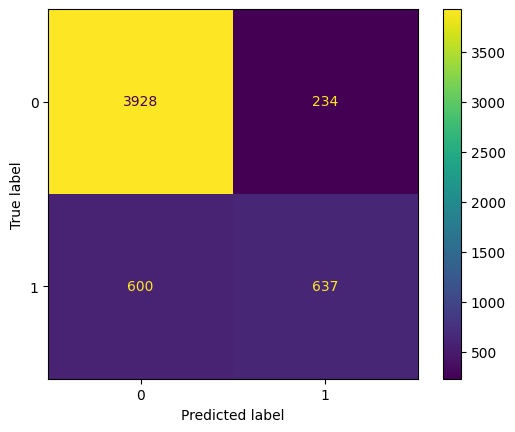

In [226]:
ConfusionMatrixDisplay(conf_matrix).plot()

In [227]:
# Print recall, accuracy of the neuralnetwork
from sklearn.metrics import recall_score, accuracy_score, precision_score

print(f"La red Neuronal predice:\n -Correctamente la días de lluvia y no lluvia en un {accuracy_score(y_test_clasificacion, predictions)} (accuracy)\n -De todos los días de lluvia, le acierta al: {recall_score(y_test_clasificacion, predictions)} (recall)\n -De todos los días de no lluvia, le acierta al {precision_score(y_test_clasificacion, predictions)} (precision) ")

La red Neuronal predice:
 -Correctamente la días de lluvia y no lluvia en un 0.8455269494350806 (accuracy)
 -De todos los días de lluvia, le acierta al: 0.5149555375909458 (recall)
 -De todos los días de no lluvia, le acierta al 0.7313432835820896 (precision) 


In [228]:
print(type(best_model))

<class 'keras.src.engine.sequential.Sequential'>


# Explicabilidad RN Clasificación

Se necesita la version de python 3.10 para correrlo

In [229]:
x_train_clasi_array = X_train_clasificacion.sample(frac=0.003, random_state=123)
x_test_clasi_array = X_test_clasificacion.sample(frac=0.003, random_state=123)

In [230]:
explainer = shap.KernelExplainer(best_model,
                            x_train_clasi_array.values,
                            feature_names=x_train_clasi_array.columns)

In [231]:
shap_values = explainer.shap_values(x_train_clasi_array)

  0%|          | 0/65 [00:00<?, ?it/s]

In [232]:
explanation = explainer(x_train_clasi_array)

  0%|          | 0/65 [00:00<?, ?it/s]

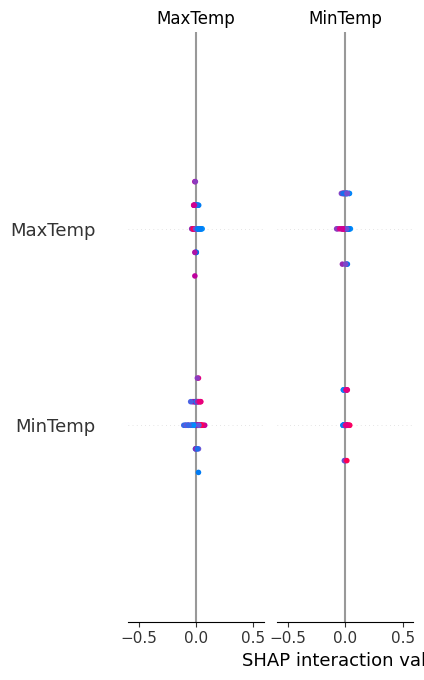

In [233]:
shap.summary_plot(shap_values, x_train_clasi_array.values, feature_names = x_train_clasi_array.columns, class_names=['Llueve', 'No llueve'])

# Conclusiones

**Clasificación:** Al comparar los valores de Precision, para el problema de clasificación, el mejor modelo es el de Regresión Logística con los hiperparametros optimizados con una Precision del *78*% seguido por las Redes Neuronales con los hiperparámetros optimizados que tiene un 73%

In [247]:
print("Regresión Lineal:")
print("----------")
print(f'Error cuadrático medio (MSE): {mse:.2f}')

print("\nRegresión Lineal con gradiente descendiente:")
print("----------")
print('Resultados con Gradiente Descendiente:')
print(f'Error cuadrático medio (MSE): {mse_sgd:.2f}')

print("\nCon regularizaciones:\n")

print('Lasso (L1):')
print("----------")
print(f"El error (rmse) de test es: {rmse_lasso}")

print('Ridge (L2):')
print("----------")
print(f"El error (rmse) de test es: {rmse_ridge}")

print("----------")
print(f'Error cuadrático medio (MSE): {mse_elastic:.2f}')

print("\nRed neuronal sin los hiperparámetros optimizados:")
print(f'MSE: {mse_nn}')

print("\nRed neuronal con los hiperparámetros optimizados:")
print(f'MSE: {valid_mse}')


Regresión Lineal:
----------
Error cuadrático medio (MSE): 0.67

Regresión Lineal con gradiente descendiente:
----------
Resultados con Gradiente Descendiente:
Error cuadrático medio (MSE): 0.66

Con regularizaciones:

Lasso (L1):
----------
El error (rmse) de test es: 0.945905874918653
Ridge (L2):
----------
El error (rmse) de test es: 0.813054241486763
----------
Error cuadrático medio (MSE): 0.69

Red neuronal sin los hiperparámetros optimizados:
MSE: 0.6517813053398711

Red neuronal con los hiperparámetros optimizados:
MSE: 0.6217395574941756


**Regresión** el modelo con mejor mse es la red neuronal con los parametros optmizados